In [ ]:
# !pip install scTDA # TDA library for single-cell RNA-seq data
### meshplot

# Ideas


**Idea 1**
1.   Use pearson correlation to get gene co-expression network
2.   Bottleneck Distance
2.   Hierachical clustering


**Idea 2**
1. PCA
1.   Euclidean distance
3.   Classification


**Idea 3**
1. Mapper






1. ~~H0 distance (for Pearson)~~
2. Euclidean PCA
3. PCA visulization?
4. Change single-observation measurement other than euclidian distance?
3. ~~Different hierachical clustering linkage method~~
4. ~~Different gene filtering threshold (current: 75%)~~
5. ~~persistence image for persistent diagram comparison~~

6. Create a graph for 11 cell types based on pairwise distance
7. check the genes compose the more prominent simplecies.

Result for H2 is not stable.

# ALL FUNCTIONS

In [ ]:
def load_and_process_h5ad(file_path):
    """
    Loads an h5ad file into an AnnData object, retrieves and prints the unique cell types and their counts.

    Parameters:
        file_path (str): The file path to the h5ad file.

    Returns:
        tuple: A tuple containing the AnnData object and an array of unique cell types.
    """
    # Load the dataset
    ds = sc.read_h5ad(file_path)

    # Retrieve unique cell types
    cell_types = ds.obs['cell_type'].unique()

    # Print the count of each cell type
    print("Cell Type Counts:")
    print(ds.obs['cell_type'].value_counts())

    # Return the dataset and the unique cell types
    return ds, cell_types

def cell_df(dataset, cell_type, reduce=True):
    """
    Filters a given dataset to only include data corresponding to a specified cell type,
    optionally reducing the dataset based on a gene expression threshold.

    Parameters:
        dataset (AnnData): The dataset to filter, typically an AnnData object.
        cell_type (str): The cell type to filter by.
        reduce (bool): If True, further filters genes that are expressed in less than 75% of the maximum cell count.

    Returns:
        DataFrame: A pandas DataFrame containing the filtered data.
    """
    cell_ds = dataset[dataset.obs['cell_type'] == str(cell_type)]
    del dataset

    n_cells = cell_ds.shape[0]

    if reduce:
        min_cell_threshold = int(np.ceil(0.75 * n_cells))
        sc.pp.filter_genes(cell_ds, min_cells=min_cell_threshold)
    cell_df = pd.DataFrame(data=cell_ds.X.toarray(), index=cell_ds.obs_names, columns=cell_ds.var_names)
    return cell_df


def corr2dist(dataframe, dim_red=False, preprocessing=False, variance=0.98):
    """
    Calculates the pairwise Pearson correlation matrix for genes in a dataframe and converts it to a distance matrix.

    Parameters:
        dataframe (DataFrame): The input data containing gene expressions.

    Returns:
        ndarray: A distance matrix derived from the Pearson correlation matrix.
    """
    if dim_red:
      data = dataframe.to_numpy()
      if preprocessing:
        pca = PCA(n_components=variance)
        pca.fit(data.T)
        data = pca.transform(data.T)

      # Initialize UMAP
      reducer = umap.UMAP(n_neighbors=15, n_components=30, metric='euclidean')

      # Fit the model and transform the data
      data = reducer.fit_transform(data)
      print('here?')
      cell_corr = pd.DataFrame(data.T).corr().to_numpy()
    else:
      cell_corr = dataframe.corr().to_numpy()
    cell_dist = np.sqrt(2 * (1 - cell_corr))
    return cell_dist

def l2_dist_mtrx(dataframe, dim_red=True, preprocessing=False, variance=0.98):
    """
    Calculates the pairwise Euclidean distance matrix for genes in a dataframe, with an option to reduce dimensionality.

    Parameters:
        dataframe (DataFrame): The dataframe containing gene expressions.
        dim_red (bool): If True, applies PCA to reduce dimensionality before calculating distances.

    Returns:
        ndarray: A pairwise Euclidean distance matrix.
    """
    data = dataframe.to_numpy().T
    if dim_red:
      if preprocessing:
        pca = PCA(n_components=variance)
        pca.fit(data)
        data = pca.transform(data)

      # Initialize UMAP
      reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean')

      # Fit the model and transform the data
      data = reducer.fit_transform(data)

    distances = pdist(data, 'euclidean')
    cell_dist = squareform(distances)
    return cell_dist

def persist_dgm(distance, maxdim=1):
    """
    Computes the persistence diagram based on a Rips filtration from a given distance matrix.

    Parameters:
        distance (ndarray): The distance matrix from which to compute the Rips filtration.

    Returns:
        list of ndarray: The computed persistence diagrams.
    """
    cell_rips = ripser(distance, distance_matrix=True, maxdim=maxdim)
    cell_diag = cell_rips['dgms']
    return cell_diag

def plot_dgm(diagram, cell_type):
    """
    Plots a persistence diagram.

    Parameters:
        diagram (list of ndarray): The persistence diagram to plot.
        cell_type (str): Label indicating the cell type, used for the plot title.
    """
    plt.rcParams.update({"text.usetex": False})
    fig, ax = plt.subplots()
    plot_diagrams(diagram, ax=ax, show=False)
    ax.set_title(str(cell_type))
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    plt.show();

def ds2dgm(dataset, cell_type, method, reduce=True, plot=True, dim_red=True, maxdim=1, preprocessing=False, variance=0.98):
    """
    Processes a dataset to create a persistence diagram for a specified cell type using a specified method.

    Parameters:
        dataset (AnnData): The dataset to process.
        cell_type (str): The cell type to process.
        method (str): The method to use for distance calculation ('pearson' or 'euclidean').
        reduce (bool): Whether to apply gene filtering.
        plot (bool): Whether to plot the resulting persistence diagram.
        dim_red (bool): Whether to apply dimensionality reduction.

    Returns:
        list of ndarray: The resulting persistence diagrams.
    """
    print('Processing cell type {}.'.format(cell_type))
    print('----dataframe')
    df = cell_df(dataset, cell_type, reduce=reduce)
    del dataset

    print('----distance')
    if method == 'pearson':
        dist = corr2dist(df, dim_red=dim_red, preprocessing=preprocessing, variance=variance)
    elif method == 'euclidean':
        dist = l2_dist_mtrx(df, dim_red=dim_red, preprocessing=preprocessing, variance=variance)
    del df

    print('----diagram')
    dgm = persist_dgm(dist, maxdim=maxdim)
    del dist

    if plot:
        plot_dgm(dgm, cell_type)

    return dgm

def ds2dgm_multi(dataset, cell_types, method='pearson', reduce=True, plot=False, dim_red=True, maxdim=1, preprocessing=False, variance=0.98):
    """
    Processes a dataset for multiple cell types to create persistence diagrams using a specified method.

    Parameters:
        dataset (AnnData): The dataset to process.
        cell_types (list of str): A list of cell types to process.
        method (str): The method to use for distance calculation ('pearson' or 'euclidean').
        reduce (bool): Whether to apply gene filtering.
        plot (bool): Whether to plot the resulting persistence diagrams.
        dim_red (bool): Whether to apply dimensionality reduction.

    Returns:
        list of list of ndarray: A list containing the persistence diagrams for each cell type.
    """
    dgms = []
    for cell_type in tqdm(cell_types):
        dgm = ds2dgm(dataset, cell_type, method, reduce=reduce, plot=plot, dim_red=dim_red, maxdim=maxdim, preprocessing=preprocessing, variance=variance)
        dgms.append(dgm)

    return dgms

def bottleneck_dist_mtrx(dgms, cell_types, dim=1):
    """
    Calculates the pairwise 1-dimensional homology bottleneck distances between persistence diagrams.

    Parameters:
        dgms (list of ndarray): A list of persistence diagrams.
        cell_types (list of str): The cell types corresponding to each diagram.
        dim (int): The dimension of homology to consider.

    Returns:
        ndarray: A matrix of bottleneck distances.
    """
    no_dgms = len(dgms)

    def distance(dgms, no_dgms, dim):
        dist_pairwise = np.array([])
        for diag_1 in tqdm(dgms):
            dist_row = np.array([])
            for diag_2 in tqdm(dgms):
                # d-dimentional homology
                dist = bottleneck(diag_1[dim], diag_2[dim])
                dist_row = np.append(dist_row, dist)
            dist_pairwise = np.append(dist_pairwise, dist_row)

        dist_pairwise = dist_pairwise.reshape(no_dgms, no_dgms)

        return dist_pairwise

    if type(dim) == str:
        dists_dim0 = distance(dgms, no_dgms, 0)
        dists_dim1 = distance(dgms, no_dgms, 1)
        dists_dim0_norm = dists_dim0 / np.linalg.norm(dists_dim0, keepdims=True)
        dists_dim1_norm = dists_dim1 / np.linalg.norm(dists_dim1, keepdims=True)

        dist_pairwise = dists_dim0_norm + dists_dim1_norm

    else:
        dist_pairwise = distance(dgms, no_dgms, dim)

    # Create a heatmap from the ndarray
    plt.rcParams.update({"text.usetex": False})
    plt.figure(figsize=(8, 6))  # Optional: specifies the figure size
    ax = sns.heatmap(dist_pairwise, cmap='coolwarm', annot=True, xticklabels=cell_types, yticklabels=cell_types)
    ax.set_title('Bottleneck Distance')  # Set the title for the heatmap
    plt.show();

    return dist_pairwise

def matrix_p_norm(matrix1, matrix2, p):
    """
    Calculates the p-norm of the difference between two matrices.

    Parameters:
        matrix1 (ndarray): The first matrix.
        matrix2 (ndarray): The second matrix.
        p (int): The order of the norm to compute.

    Returns:
        float: The p-norm of the difference between matrix1 and matrix2.
    """
    difference = matrix1 - matrix2
    return np.linalg.norm(difference, ord=p)

def persistence_img_norms(imgs, valid_types, p=2, plot=True):
    """
    Computes the p-norms for pairs of normalized persistence images.

    Parameters:
        imgs (list of ndarray): List of persistence images.
        valid_types (list of str): List of valid types corresponding to each image.
        p (int): The order of the norm.
        plot (bool): If True, plots a heatmap of the p-norms.

    Returns:
        ndarray: A matrix of p-norms between all pairs of images.
    """
    p_norms = []
    for img1 in imgs:
        for img2 in imgs:
            p_norm = matrix_p_norm(img1, img2, p=p)
            p_norms.append(p_norm)

    p_norms = np.array(p_norms).reshape(len(imgs), -1)
    if plot:
        plt.rcParams.update({"text.usetex": False})
        plt.figure(figsize=(8, 6))
        ax = sns.heatmap(p_norms, cmap='coolwarm', annot=True, xticklabels=valid_types, yticklabels=valid_types)
        ax.set_title('p-norms of persistence vector distance')
        plt.show();

    return p_norms

def persistence_img(pdgms, cell_type, plot=False, start=0.0, end=1.0):
    """
    Generates a persistence image from the given persistence diagrams.

    Parameters:
        pdgms (list of ndarray): List of persistence diagrams.
        cell_type (str): The cell type associated with the diagrams.
        plot (bool): If True, plots the diagrams and their persistence image.

    Returns:
        ndarray: The generated persistence image.
    """
    mask = np.any(np.isinf(pdgms), axis=1)
    pdgms = pdgms[~mask]


    pimgr = PersistenceImager(pixel_size=0.01, birth_range=(0,1))
    # persistences = pdgms[:, 1] - pdgms[:, 0]
    # weights = persistences  # Direct use of persistence as weight

    pimgr.weight = linear_ramp
    pimgr.weight_params = {'low':0.0, 'high':1.0, 'start':start, 'end':end}
    pimgr.fit(pdgms, skew=True)
    pimgs = pimgr.transform(pdgms, skew=True)

    if pimgs.shape[0] == 0:
        message = '{} not applicable'.format(cell_type)
        print(message.title())
        return message.title()

    if plot:
        plt.rcParams.update({"text.usetex": False})
        fig, axs = plt.subplots(1, 3, figsize=(12,5))

        axs[0].set_title("Original Diagram")
        pimgr.plot_diagram(pdgms, skew=False, ax=axs[0])
        axs[1].set_title("Birth-Persistence\nCoordinates")
        pimgr.plot_diagram(pdgms, skew=True, ax=axs[1])
        axs[2].set_title("Persistence Image")
        pimgr.plot_image(pimgs, ax=axs[2])

        plt.tight_layout();

    return pimgs

def pad_with_zeros(small_matrix, target_shape):
    """
    Pads a smaller matrix with zeros to fit the target shape.
    Assumes target_shape is larger or equal to small_matrix's shape in both dimensions.
    """
    padded_matrix = np.zeros(target_shape)
    padded_matrix[:small_matrix.shape[0], :small_matrix.shape[1]] = small_matrix
    return padded_matrix


def persistence_img_resize(dgms, cell_types, new_shape=(10, 3), padding=True, plot=False, start=0.0, end=1.0):
    """
    Resizes the persistence images to a new shape.

    Parameters:
        dgms (list of ndarray): List of persistence diagrams.
        cell_types (list of str): List of cell types associated with each diagram.
        new_shape (tuple): The new shape to which the images will be resized.

    Returns:
        tuple: A tuple containing the resized images and the types of the cells that were processed.
    """
    imgs = []
    valid_types = []
    x_size = []
    y_size = []
    for dgm, cell_type in zip(dgms, cell_types):
        img = persistence_img(dgm[1], cell_type, plot=plot, start=start, end=end)
        if type(img) == str:  # "Not Applicable"
            continue
        imgs.append(img)
        x_size.append(img.shape[0])
        y_size.append(img.shape[1])
        valid_types.append(cell_type)

    if padding:
      new_shape = (np.max(x_size), np.max(y_size))
      img_reduced = np.array([pad_with_zeros(img, new_shape) for img in imgs])

    else:
      img_reduced = np.array([cv2.resize(img, new_shape, interpolation=cv2.INTER_LINEAR) for img in imgs])

    return img_reduced, np.array(valid_types)


def plot_dendrogram(dists, cell_types, method='average'):
    """
    Plots a dendrogram from the distance matrix using hierarchical clustering.

    Parameters:
        dists (ndarray): The distance matrix.
        cell_types (list of str): List of labels corresponding to each row/column in the distance matrix.
        method (str): The linkage method used for clustering ('average', 'single', 'complete', etc.).

    """
    condensed_dists = squareform(dists, checks=False)
    Z = linkage(condensed_dists, method=method)
    plt.rcParams.update({"text.usetex": False})
    plt.figure(figsize=(12, 5))
    dendrogram(Z, labels=cell_types, leaf_rotation=90, leaf_font_size=12)
    plt.title('Hierarchical Clustering Dendrogram with {} Linkage'.format(method.capitalize()))
    plt.xlabel('Cell Type')
    plt.ylabel('Distance')
    plt.show();


# Installation

In [ ]:
%%capture
!pip install scanpy # read h5ad file
!pip install gudhi # TDA library
!pip install Cython
!pip install Ripser
!pip install -U giotto-tda
!pip install scikit-image
!pip install opencv-python
!pip install kneed
# !pip install dask[complete]  # Includes complete installation with all optional dependencies
!pip install umap-learn
# !pip install dionysus


# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
# import dask.dataframe as dd
# from dask.distributed import Client
# import dask.array as da
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": False})
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
import scipy.sparse as sp
from scipy.stats import pearsonr
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.measure import block_reduce
import cv2
from tqdm.notebook import tqdm
from kneed import KneeLocator
import umap
import numpy as np
from sklearn.neighbors import NearestNeighbors


import scanpy as sc
import warnings
from anndata import ImplicitModificationWarning
warnings.filterwarnings('ignore', category=ImplicitModificationWarning)
warnings.filterwarnings('ignore', message="dgm1 has points with non-finite death times; ignoring those points")
warnings.filterwarnings('ignore', message="dgm2 has points with non-finite death times; ignoring those points")

import gudhi as gd
from ripser import ripser, Rips
from persim import plot_diagrams, PersistenceImager, bottleneck
from persim.images_weights import linear_ramp
import gtda
from gtda.diagrams import PersistenceImage

# Data viz
from gtda.plotting import plot_point_cloud

# TDA magic
from gtda.mapper import (
    CubicalCover,
    OneDimensionalCover,
    FirstSimpleGap,
    Eccentricity,
    Entropy,
    FirstHistogramGap,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
)

# import dionysus as d

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

## Basics
- data loading
- cell type dataframe
- plot persistent diagram
- plot dendrogram
- df2dgm & df2dgm_multi

In [ ]:
# def load_and_process_h5ad(file_path):
#     """
#     Loads an h5ad file into an AnnData object, retrieves and prints the unique cell types and their counts.

#     Parameters:
#         file_path (str): The file path to the h5ad file.

#     Returns:
#         tuple: A tuple containing the AnnData object and an array of unique cell types.
#     """
#     # Load the dataset
#     ds = sc.read_h5ad(file_path)

#     # Retrieve unique cell types
#     cell_types = ds.obs['cell_type'].unique()

#     # Print the count of each cell type
#     print("Cell Type Counts:")
#     print(ds.obs['cell_type'].value_counts())

#     # Return the dataset and the unique cell types
#     return ds, cell_types

def load_and_process_h5ad(file_path, filter_method='highly_expressed'):
    """
    Loads an h5ad file into an AnnData object, retrieves and prints the unique cell types and their counts,
    normalizes and log-transforms the data, and keeps only the top 1500 highly variable genes.

    Parameters:
        file_path (str): The file path to the h5ad file.

    Returns:
        tuple: A tuple containing the AnnData object and an array of unique cell types.
    """
    # Load the dataset
    ds = sc.read_h5ad(file_path)

    # Normalize the data
    sc.pp.normalize_total(ds, target_sum=1e6)

    # Log-transform the data
    sc.pp.log1p(ds)

    if filter_method == 'highly_variable':
      # Identify highly variable genes
      sc.pp.highly_variable_genes(ds, n_top_genes=1000)

      # Filter the dataset to keep only highly variable genes
      ds = ds[:, ds.var['highly_variable']]

    # Retrieve unique cell types
    cell_types = ds.obs['cell_type'].unique()

    # Print the count of each cell type
    print("Cell Type Counts:")
    print(ds.obs['cell_type'].value_counts())

    # Return the dataset and the unique cell types
    return ds, cell_types

def cell_df(dataset, cell_type, reduce=True):
    """
    Filters a given dataset to only include data corresponding to a specified cell type,
    optionally reducing the dataset based on a gene expression threshold.

    Parameters:
        dataset (AnnData): The dataset to filter, typically an AnnData object.
        cell_type (str): The cell type to filter by.
        reduce (bool): If True, further filters genes that are expressed in less than 75% of the maximum cell count.

    Returns:
        DataFrame: A pandas DataFrame containing the filtered data.
    """
    cell_ds = dataset[dataset.obs['cell_type'] == str(cell_type)]
    del dataset

    if reduce:
      n_cells = cell_ds.shape[0]
      min_cell_threshold = int(np.ceil(0.75 * n_cells))
      sc.pp.filter_genes(cell_ds, min_cells=min_cell_threshold)

    cell_df = pd.DataFrame(data=cell_ds.X.toarray(), index=cell_ds.obs_names, columns=cell_ds.var_names)
    return cell_df

def plot_dendrogram(dists, cell_types, method='average'):
  """
  Plots a dendrogram from the distance matrix using hierarchical clustering.

  Parameters:
      dists (ndarray): The distance matrix.
      cell_types (list of str): List of labels corresponding to each row/column in the distance matrix.
      method (str): The linkage method used for clustering ('average', 'single', 'complete', etc.).

  """
  condensed_dists = squareform(dists, checks=False)
  Z = linkage(condensed_dists, method=method)
  plt.rcParams.update({"text.usetex": False})
  plt.figure(figsize=(12, 5))
  dendrogram(Z, labels=cell_types, leaf_rotation=90, leaf_font_size=12)
  plt.title('Hierarchical Clustering Dendrogram with {} Linkage'.format(method.capitalize()))
  plt.xlabel('Cell Type')
  plt.ylabel('Distance')
  plt.show();


In [ ]:
def persist_dgm(distance, maxdim=1):
    """
    Computes the persistence diagram based on a Rips filtration from a given distance matrix.

    Parameters:
        distance (ndarray): The distance matrix from which to compute the Rips filtration.

    Returns:
        list of ndarray: The computed persistence diagrams.
    """
    cell_rips = ripser(distance, distance_matrix=True, maxdim=maxdim)
    cell_diag = cell_rips['dgms']
    return cell_diag

def plot_dgm(diagram, cell_type):
    """
    Plots a persistence diagram.

    Parameters:
        diagram (list of ndarray): The persistence diagram to plot.
        cell_type (str): Label indicating the cell type, used for the plot title.
    """
    plt.rcParams.update({"text.usetex": False})
    fig, ax = plt.subplots()
    plot_diagrams(diagram, ax=ax, show=False)
    ax.set_title(str(cell_type))
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    plt.show();

def ds2dgm(dataset, cell_type, method, reduce=True, plot=True, dim_red=True, maxdim=1, preprocessing=False, variance=0.98):
    """
    Processes a dataset to create a persistence diagram for a specified cell type using a specified method.

    Parameters:
        dataset (AnnData): The dataset to process.
        cell_type (str): The cell type to process.
        method (str): The method to use for distance calculation ('pearson' or 'euclidean').
        reduce (bool): Whether to apply gene filtering.
        plot (bool): Whether to plot the resulting persistence diagram.
        dim_red (bool): Whether to apply dimensionality reduction.

    Returns:
        list of ndarray: The resulting persistence diagrams.
    """
    print('Processing cell type {}.'.format(cell_type))
    print('----dataframe')
    df = cell_df(dataset, cell_type, reduce=reduce)
    del dataset

    print('----distance')
    if method == 'pearson':
        dist = corr2dist(df, dim_red=dim_red, preprocessing=preprocessing, variance=variance)
    elif method == 'euclidean':
        dist = l2_dist_mtrx(df, dim_red=dim_red, preprocessing=preprocessing, variance=variance)
    del df

    print('----diagram')
    dgm = persist_dgm(dist, maxdim=maxdim)
    del dist

    if plot:
        plot_dgm(dgm, cell_type)

    return dgm

def ds2dgm_multi(dataset, cell_types, method='pearson', reduce=True, plot=False, dim_red=True, maxdim=1, preprocessing=False, variance=0.98):
    """
    Processes a dataset for multiple cell types to create persistence diagrams using a specified method.

    Parameters:
        dataset (AnnData): The dataset to process.
        cell_types (list of str): A list of cell types to process.
        method (str): The method to use for distance calculation ('pearson' or 'euclidean').
        reduce (bool): Whether to apply gene filtering.
        plot (bool): Whether to plot the resulting persistence diagrams.
        dim_red (bool): Whether to apply dimensionality reduction.

    Returns:
        list of list of ndarray: A list containing the persistence diagrams for each cell type.
    """
    dgms = []
    for cell_type in tqdm(cell_types):
        dgm = ds2dgm(dataset, cell_type, method, reduce=reduce, plot=plot, dim_red=dim_red, maxdim=maxdim, preprocessing=preprocessing, variance=variance)
        dgms.append(dgm)

    return dgms

## distance metrics
- pearson correlation
- euclidean distance
- bottleneck distance
- matrix normlization


In [ ]:
def corr2dist(dataframe, dim_red=False, preprocessing=False, variance=0.98):
    """
    Calculates the pairwise Pearson correlation matrix for genes in a dataframe and converts it to a distance matrix.

    Parameters:
        dataframe (DataFrame): The input data containing gene expressions.

    Returns:
        ndarray: A distance matrix derived from the Pearson correlation matrix.
    """
    if dim_red:
      data = dataframe.to_numpy()
      if preprocessing:
        pca = PCA(n_components=variance)
        pca.fit(data.T)
        data = pca.transform(data.T)
        print(data.shape)

      # Initialize UMAP
      reducer = umap.UMAP(n_neighbors=15, n_components=30, metric='euclidean')

      # Fit the model and transform the data
      data = reducer.fit_transform(data)
      print('here?')
      cell_corr = pd.DataFrame(data.T).corr().to_numpy()
    else:
      cell_corr = dataframe.corr().to_numpy()
    cell_dist = np.sqrt(2 * (1 - cell_corr))
    return cell_dist

def l2_dist_mtrx(dataframe, dim_red=True, preprocessing=False, variance=0.98):
    """
    Calculates the pairwise Euclidean distance matrix for genes in a dataframe, with an option to reduce dimensionality.

    Parameters:
        dataframe (DataFrame): The dataframe containing gene expressions.
        dim_red (bool): If True, applies PCA to reduce dimensionality before calculating distances.

    Returns:
        ndarray: A pairwise Euclidean distance matrix.
    """
    data = dataframe.to_numpy().T
    if dim_red:
      if preprocessing:
        pca = PCA(n_components=variance)
        pca.fit(data)
        data = pca.transform(data)
        print(data.shape)
      # Initialize UMAP
      reducer = umap.UMAP(n_neighbors=15, n_components=15, metric='euclidean')

      # Fit the model and transform the data
      data = reducer.fit_transform(data)

    distances = pdist(data, 'euclidean')
    cell_dist = squareform(distances)
    return cell_dist


def bottleneck_dist_mtrx(dgms, cell_types, dim=1):
    """
    Calculates the pairwise 1-dimensional homology bottleneck distances between persistence diagrams.

    Parameters:
        dgms (list of ndarray): A list of persistence diagrams.
        cell_types (list of str): The cell types corresponding to each diagram.
        dim (int): The dimension of homology to consider.

    Returns:
        ndarray: A matrix of bottleneck distances.
    """
    no_dgms = len(dgms)

    def distance(dgms, no_dgms, dim):
        dist_pairwise = np.array([])
        for diag_1 in tqdm(dgms):
            dist_row = np.array([])
            for diag_2 in tqdm(dgms):
                # d-dimentional homology
                dist = bottleneck(diag_1[dim], diag_2[dim])
                dist_row = np.append(dist_row, dist)
            dist_pairwise = np.append(dist_pairwise, dist_row)

        dist_pairwise = dist_pairwise.reshape(no_dgms, no_dgms)

        return dist_pairwise

    if type(dim) == str:
        dists_dim0 = distance(dgms, no_dgms, 0)
        dists_dim1 = distance(dgms, no_dgms, 1)
        dists_dim0_norm = dists_dim0 / np.linalg.norm(dists_dim0, keepdims=True)
        dists_dim1_norm = dists_dim1 / np.linalg.norm(dists_dim1, keepdims=True)

        dist_pairwise = dists_dim0_norm + dists_dim1_norm

    else:
        dist_pairwise = distance(dgms, no_dgms, dim)

    # Create a heatmap from the ndarray
    plt.rcParams.update({"text.usetex": False})
    plt.figure(figsize=(8, 6))  # Optional: specifies the figure size
    ax = sns.heatmap(dist_pairwise, cmap='coolwarm', annot=True, xticklabels=cell_types, yticklabels=cell_types)
    ax.set_title('Bottleneck Distance')  # Set the title for the heatmap
    plt.show();

    return dist_pairwise

## persistence image
- image calculation
- padding
- image norms
- image resize

In [ ]:
def matrix_p_norm(matrix1, matrix2, p):
    """
    Calculates the p-norm of the difference between two matrices.

    Parameters:
        matrix1 (ndarray): The first matrix.
        matrix2 (ndarray): The second matrix.
        p (int): The order of the norm to compute.

    Returns:
        float: The p-norm of the difference between matrix1 and matrix2.
    """
    difference = matrix1 - matrix2
    return np.linalg.norm(difference, ord=p)

def persistence_img_norms(imgs, valid_types, p=2, plot=True):
    """
    Computes the p-norms for pairs of normalized persistence images.

    Parameters:
        imgs (list of ndarray): List of persistence images.
        valid_types (list of str): List of valid types corresponding to each image.
        p (int): The order of the norm.
        plot (bool): If True, plots a heatmap of the p-norms.

    Returns:
        ndarray: A matrix of p-norms between all pairs of images.
    """
    p_norms = []
    for img1 in imgs:
        for img2 in imgs:
            p_norm = matrix_p_norm(img1, img2, p=p)
            p_norms.append(p_norm)

    p_norms = np.array(p_norms).reshape(len(imgs), -1)
    if plot:
        plt.rcParams.update({"text.usetex": False})
        plt.figure(figsize=(8, 6))
        ax = sns.heatmap(p_norms, cmap='coolwarm', annot=True, xticklabels=valid_types, yticklabels=valid_types)
        ax.set_title('p-norms of persistence vector distance')
        plt.show();

    return p_norms

def persistence_img(pdgms, cell_type, plot=False, start=0.0, end=1.0):
    """
    Generates a persistence image from the given persistence diagrams.

    Parameters:
        pdgms (list of ndarray): List of persistence diagrams.
        cell_type (str): The cell type associated with the diagrams.
        plot (bool): If True, plots the diagrams and their persistence image.

    Returns:
        ndarray: The generated persistence image.
    """
    mask = np.any(np.isinf(pdgms), axis=1)
    pdgms = pdgms[~mask]


    pimgr = PersistenceImager(pixel_size=0.01, birth_range=(0,1))
    # persistences = pdgms[:, 1] - pdgms[:, 0]
    # weights = persistences  # Direct use of persistence as weight

    pimgr.weight = linear_ramp
    pimgr.weight_params = {'low':0.0, 'high':1.0, 'start':start, 'end':end}
    pimgr.fit(pdgms, skew=True)
    pimgs = pimgr.transform(pdgms, skew=True)

    if pimgs.shape[0] == 0:
        message = '{} not applicable'.format(cell_type)
        print(message.title())
        return message.title()

    if plot:
        plt.rcParams.update({"text.usetex": False})
        fig, axs = plt.subplots(1, 3, figsize=(12,5))

        axs[0].set_title("Original Diagram")
        pimgr.plot_diagram(pdgms, skew=False, ax=axs[0])
        axs[1].set_title("Birth-Persistence\nCoordinates")
        pimgr.plot_diagram(pdgms, skew=True, ax=axs[1])
        axs[2].set_title("Persistence Image")
        pimgr.plot_image(pimgs, ax=axs[2])

        plt.tight_layout();

    return pimgs

def pad_with_zeros(small_matrix, target_shape):
    """
    Pads a smaller matrix with zeros to fit the target shape.
    Assumes target_shape is larger or equal to small_matrix's shape in both dimensions.
    """
    padded_matrix = np.zeros(target_shape)
    padded_matrix[:small_matrix.shape[0], :small_matrix.shape[1]] = small_matrix
    return padded_matrix


def persistence_img_resize(dgms, cell_types, new_shape=(10, 3), padding=True, plot=False, start=0.0, end=1.0):
    """
    Resizes the persistence images to a new shape.

    Parameters:
        dgms (list of ndarray): List of persistence diagrams.
        cell_types (list of str): List of cell types associated with each diagram.
        new_shape (tuple): The new shape to which the images will be resized.

    Returns:
        tuple: A tuple containing the resized images and the types of the cells that were processed.
    """
    imgs = []
    valid_types = []
    x_size = []
    y_size = []
    for dgm, cell_type in zip(dgms, cell_types):
        img = persistence_img(dgm[1], cell_type, plot=plot, start=start, end=end)
        if type(img) == str:  # "Not Applicable"
            continue
        imgs.append(img)
        x_size.append(img.shape[0])
        y_size.append(img.shape[1])
        valid_types.append(cell_type)

    if padding:
      new_shape = (np.max(x_size), np.max(y_size))
      img_reduced = np.array([pad_with_zeros(img, new_shape) for img in imgs])

    else:
      img_reduced = np.array([cv2.resize(img, new_shape, interpolation=cv2.INTER_LINEAR) for img in imgs])

    return img_reduced, np.array(valid_types)

# Data Loading

In [ ]:
file_path = '/content/drive/MyDrive/9343817c-5c74-4548-a7d5-01990df5af7a.h5ad'
ds, cell_types = load_and_process_h5ad(file_path, filter_method='highly_expressed')

Cell Type Counts:
cell_type
oligodendrocyte                           494966
astrocyte                                 155025
oligodendrocyte precursor cell            105734
central nervous system macrophage          91838
fibroblast                                  9156
Bergmann glial cell                         8041
choroid plexus epithelial cell              7689
ependymal cell                              5882
endothelial cell                            5165
pericyte                                    3693
vascular associated smooth muscle cell      1074
Name: count, dtype: int64


# Hierachical Clustering with Pearson Correlation (~~Testing H2~~ H2 is not stable -> might not have spheres)

(103, 96)
here?


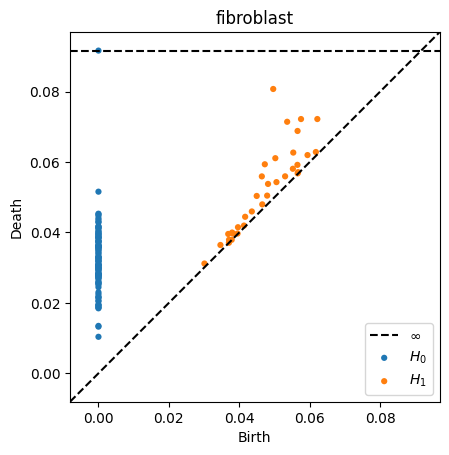

In [ ]:
f_df = cell_df(ds, 'fibroblast', reduce=True)
f_corr = corr2dist(f_df, dim_red=True, preprocessing=True, variance=0.99)
f_dgm = persist_dgm(f_corr, maxdim=1)
plot_dgm(f_dgm, 'fibroblast')

In [ ]:
### Distance calculated with 2-dim homology
dists_dim2 = bottleneck_dist_mtrx(dgms[:2], ['fibroblast', 'vascular associated smooth muscle cell', 'choroid plexus epithelial cell'], dim=2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

ValueError: Must pass 2-d input. shape=()

<Figure size 800x600 with 0 Axes>

## w/o dimensional reduction

### dgms

  0%|          | 0/11 [00:00<?, ?it/s]

Processing cell type oligodendrocyte.
----dataframe
----distance
----diagram


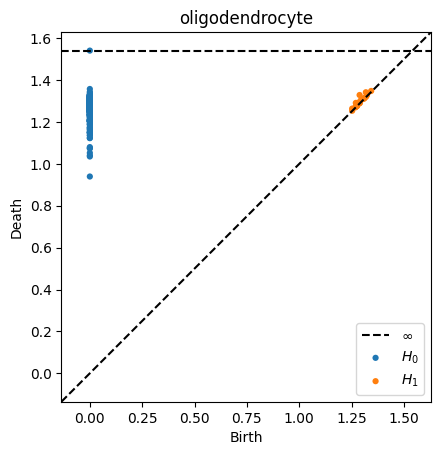

Processing cell type astrocyte.
----dataframe
----distance
----diagram


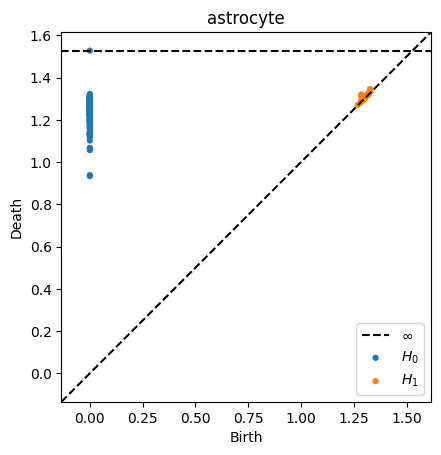

Processing cell type Bergmann glial cell.
----dataframe
----distance
----diagram


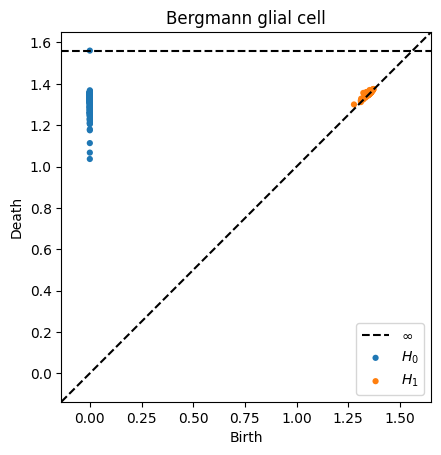

Processing cell type oligodendrocyte precursor cell.
----dataframe
----distance
----diagram


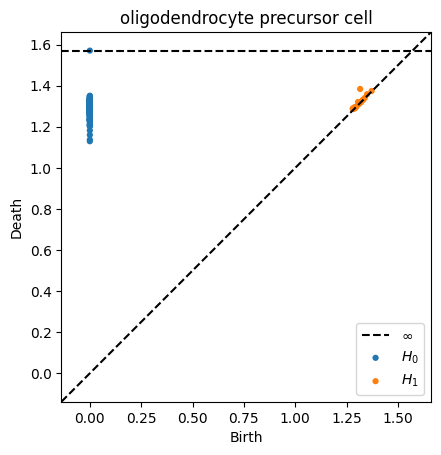

Processing cell type ependymal cell.
----dataframe
----distance
----diagram


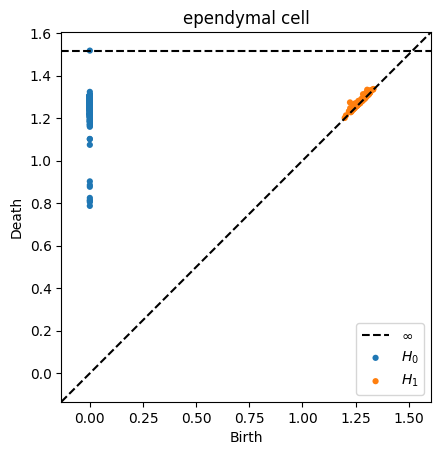

Processing cell type choroid plexus epithelial cell.
----dataframe
----distance
----diagram


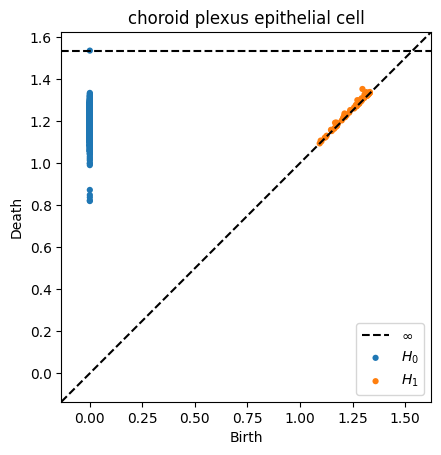

Processing cell type fibroblast.
----dataframe
----distance
----diagram


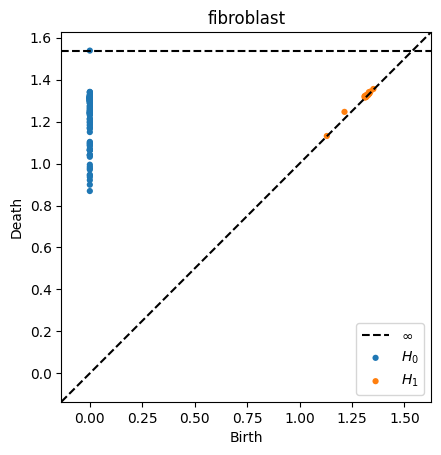

Processing cell type pericyte.
----dataframe
----distance
----diagram


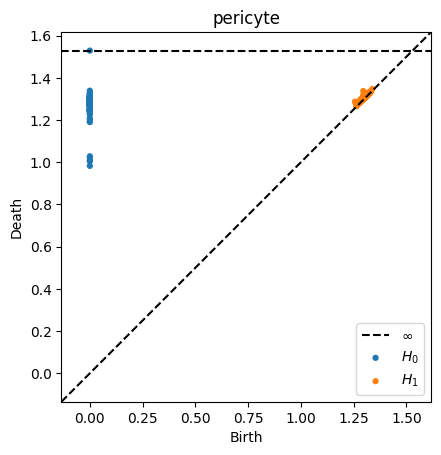

Processing cell type vascular associated smooth muscle cell.
----dataframe
----distance
----diagram


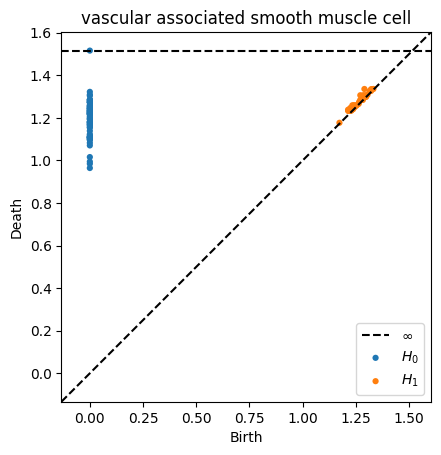

Processing cell type endothelial cell.
----dataframe
----distance
----diagram


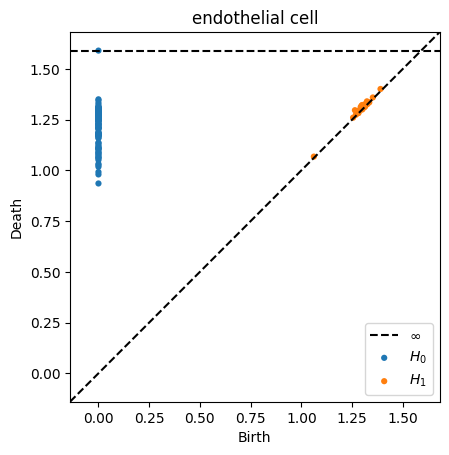

Processing cell type central nervous system macrophage.
----dataframe
----distance
----diagram


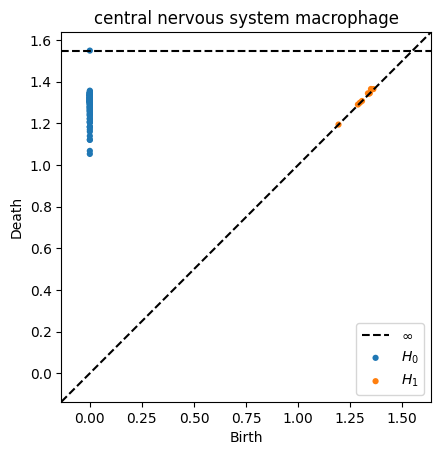

In [ ]:
### Hierachical clustering with pearson distance
# dgms = ds2dgm_multi(ds, cell_types, method='pearson', reduce=True, plot=True, dim_red=True)
dgms = ds2dgm_multi(ds, cell_types, method='pearson', reduce=True, plot=True, dim_red=False, maxdim=1, preprocessing=True, variance=0.99)

### 1-dim distance

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

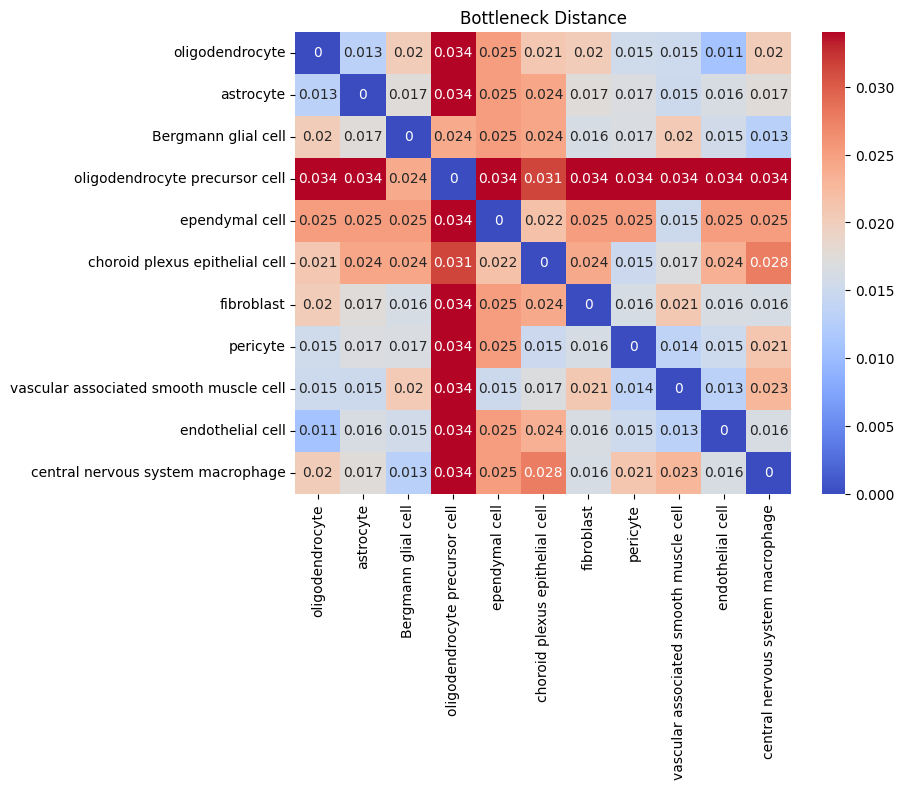

In [ ]:
### Distance calculated with 1-dim homology
dists_dim1 = bottleneck_dist_mtrx(dgms, cell_types, dim=1)

### dendrogram

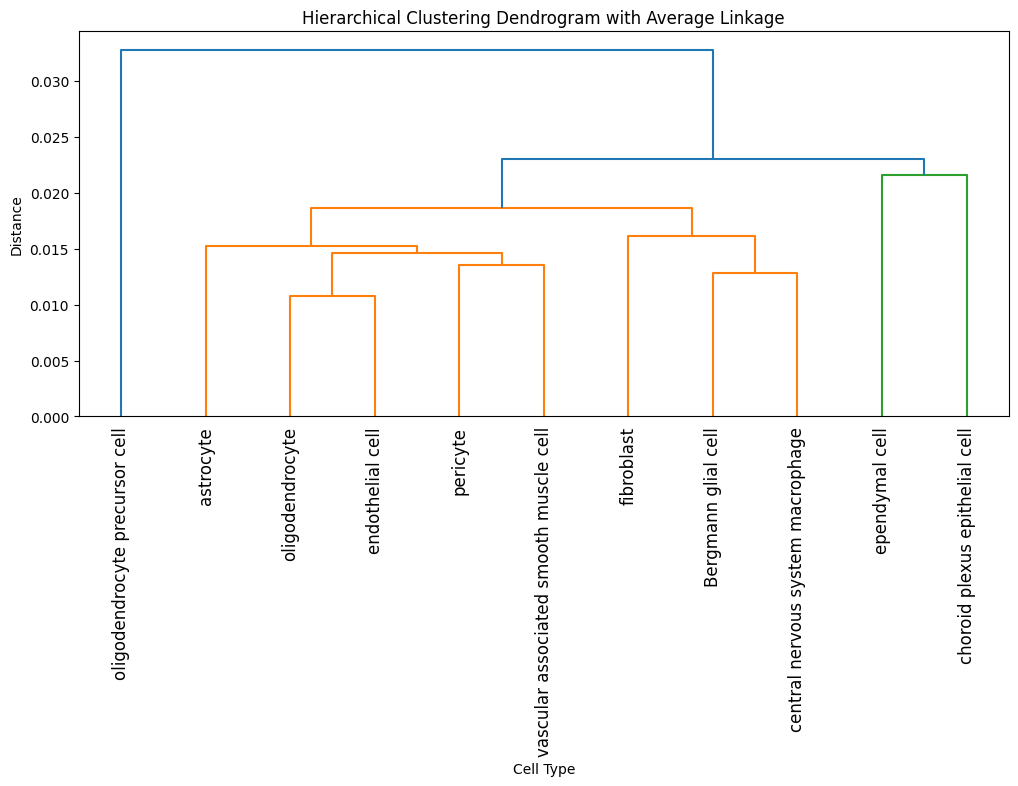

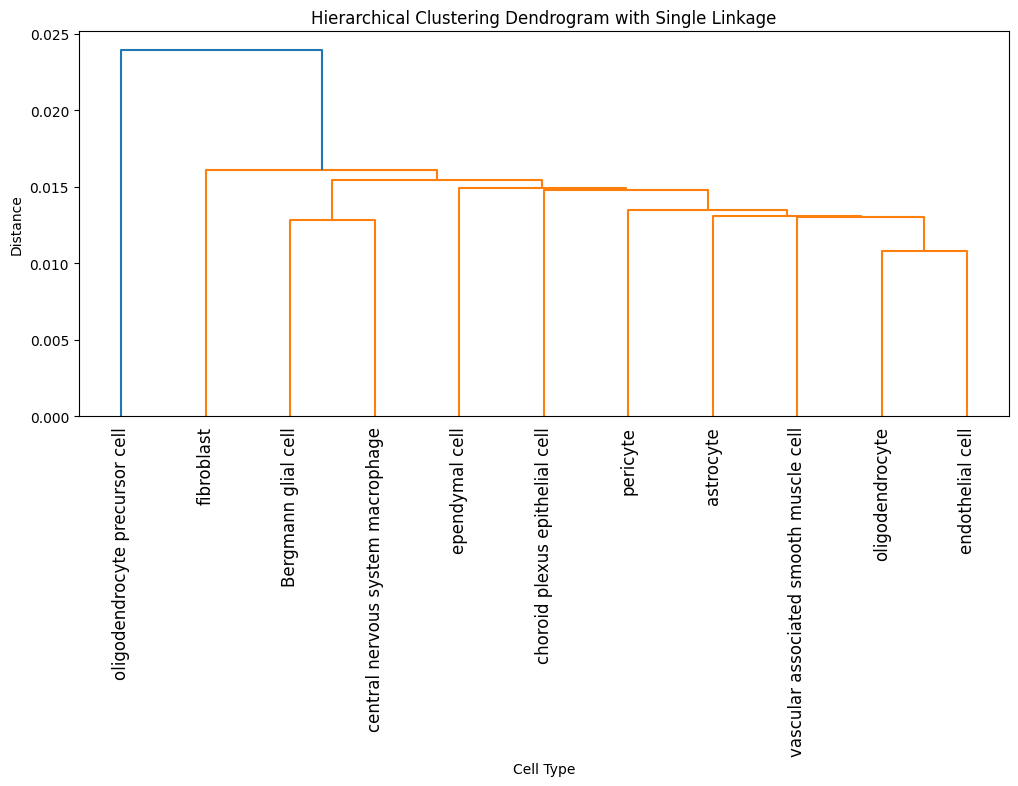

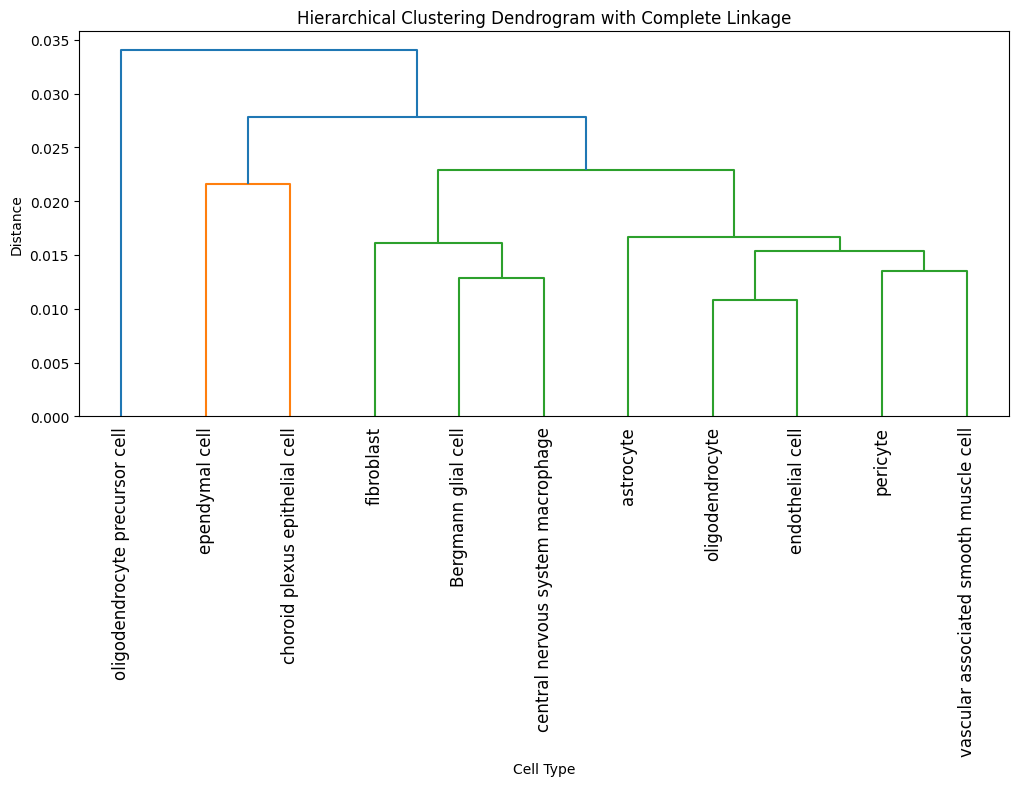

In [ ]:
# dendrogram with 1-dim homology
plot_dendrogram(dists_dim1, cell_types, method='average')
plot_dendrogram(dists_dim1, cell_types, method='single')
plot_dendrogram(dists_dim1, cell_types, method='complete')

### 0-dim distance

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
Exception ignored in: <function _xla_gc_callback at 0x7fd4d583bac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

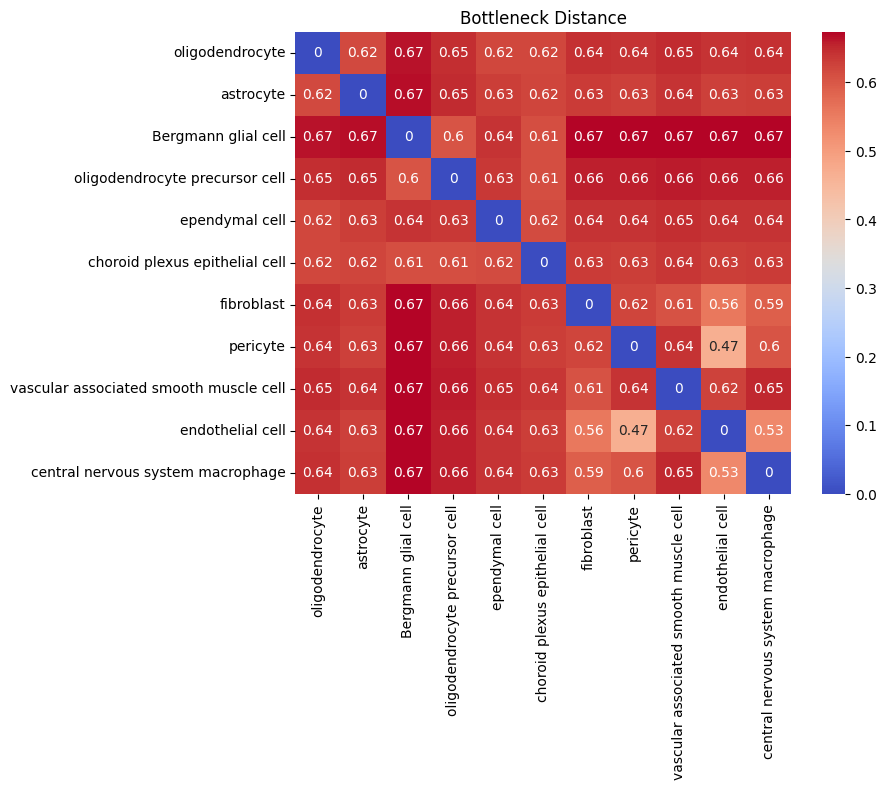

In [ ]:
### Distance calculated with 0-dim homology
dists_dim0 = bottleneck_dist_mtrx(dgms, cell_types, dim=0)

### dendrogram

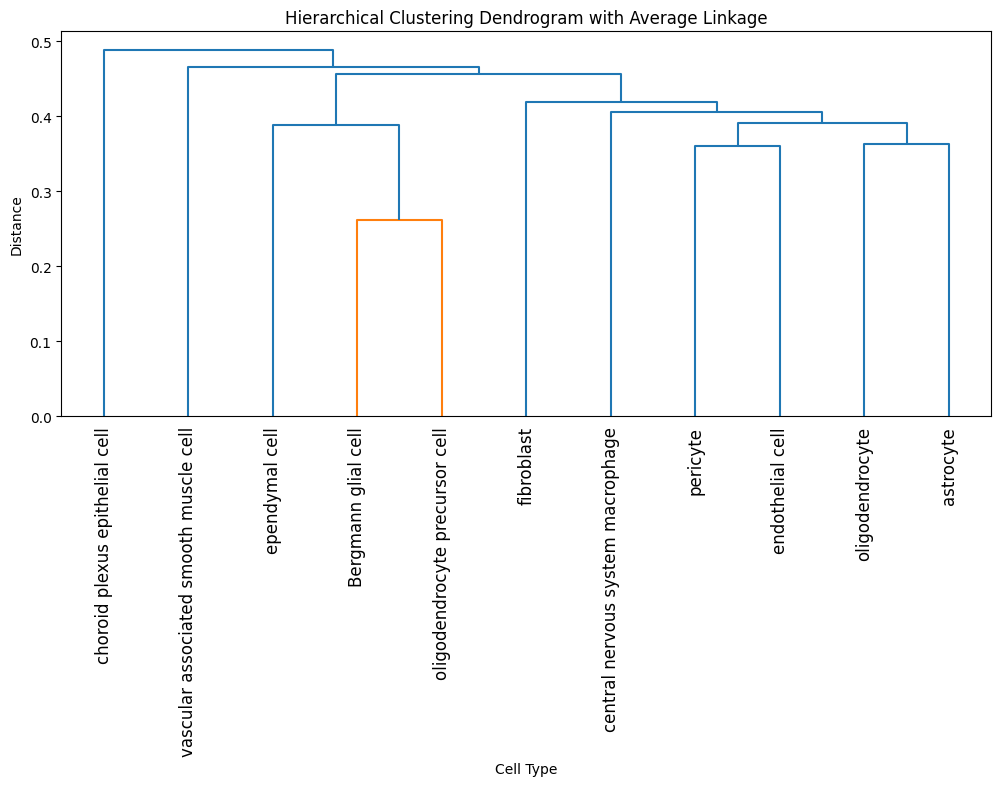

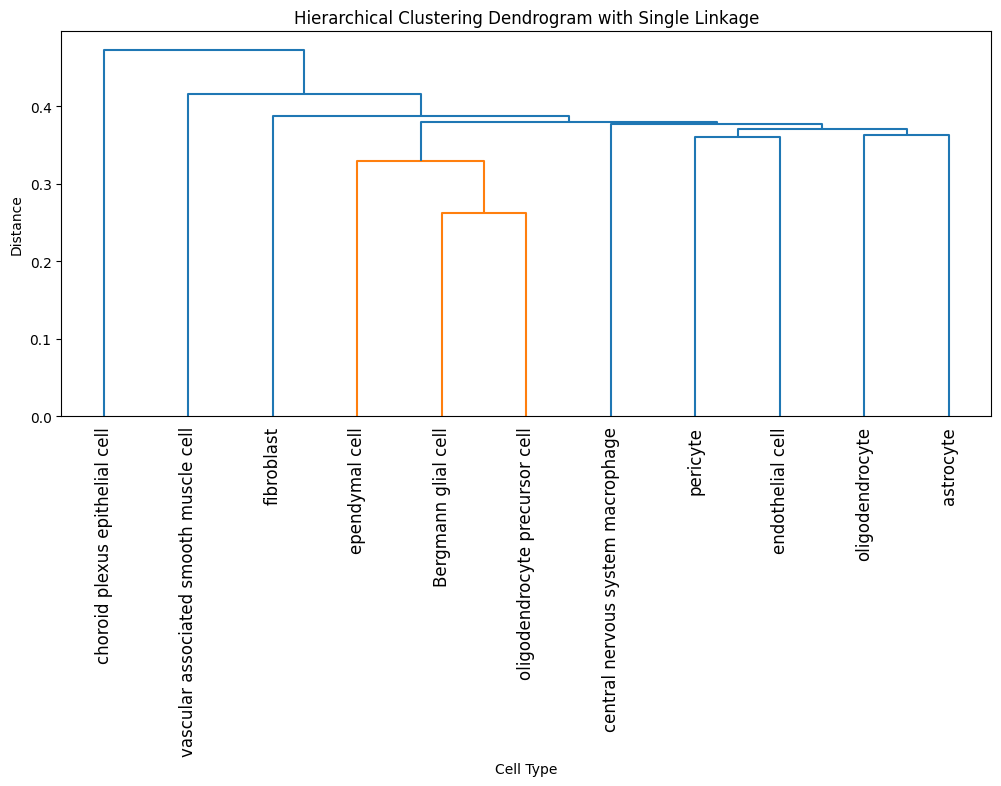

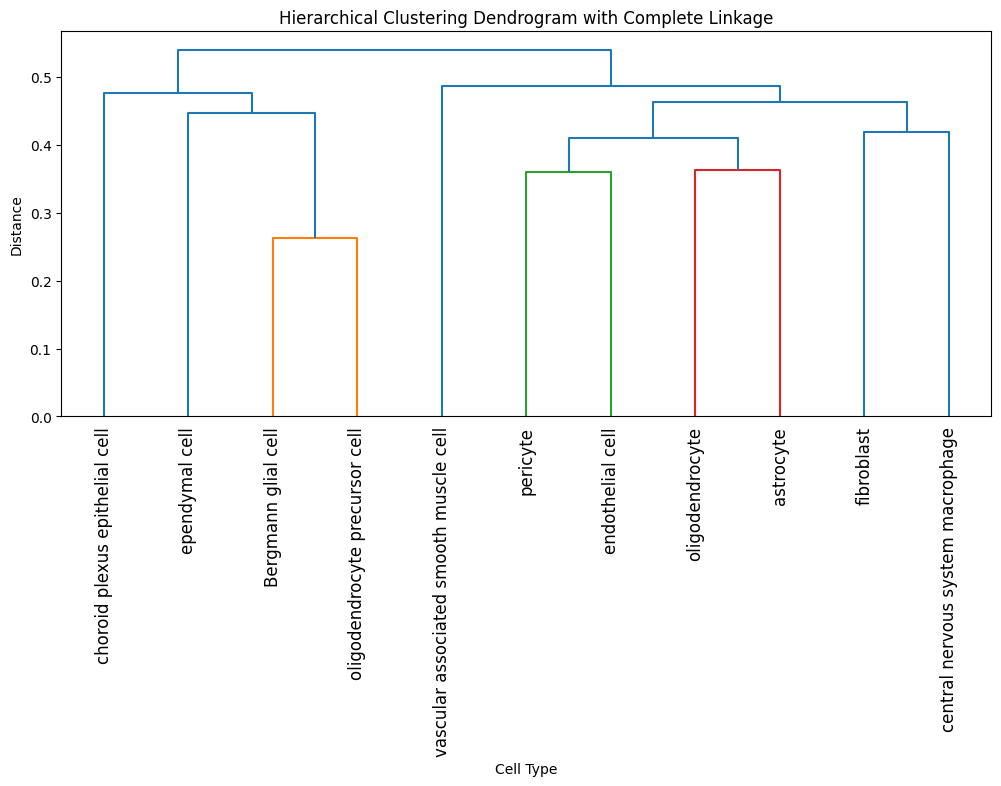

In [ ]:
# dendrogram with 0-dim homology
plot_dendrogram(dists_dim0, method='average')
plot_dendrogram(dists_dim0, method='single')
plot_dendrogram(dists_dim0, method='complete')

### combined distance & dendrogram

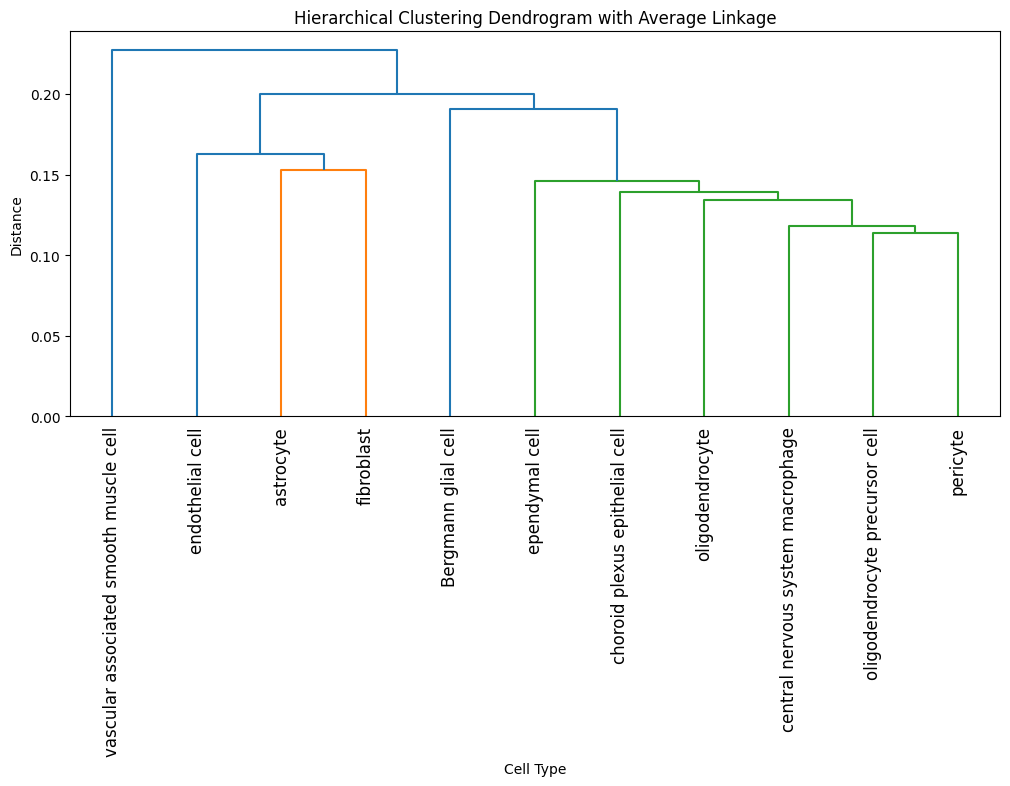

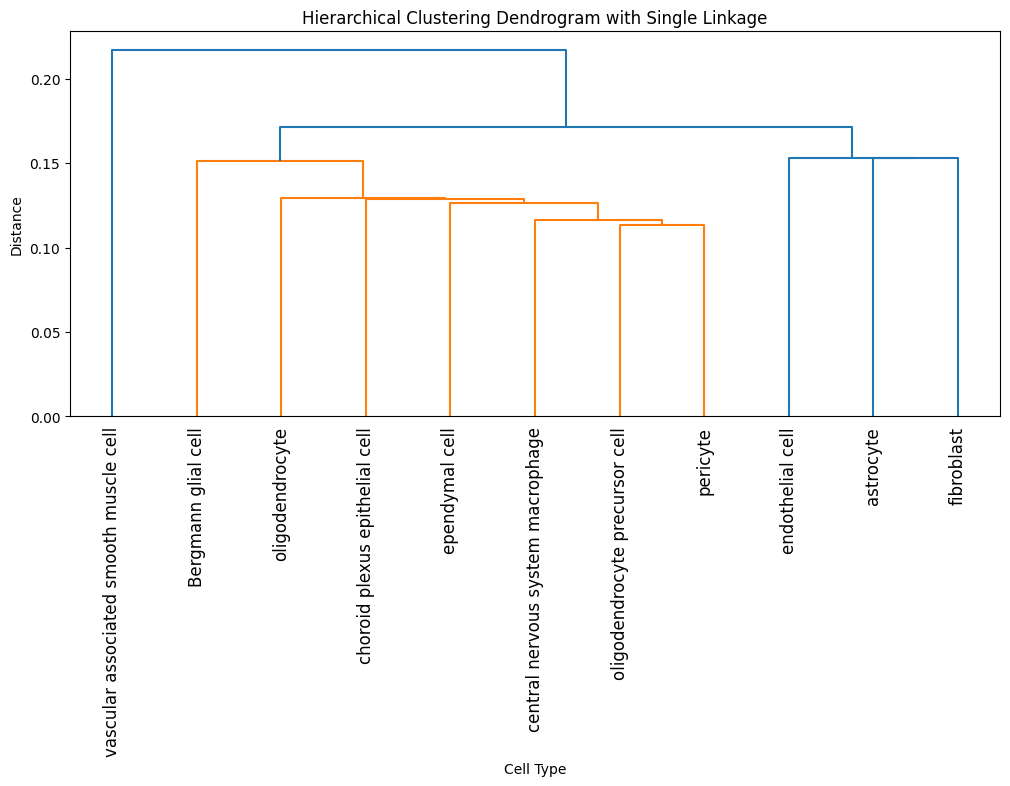

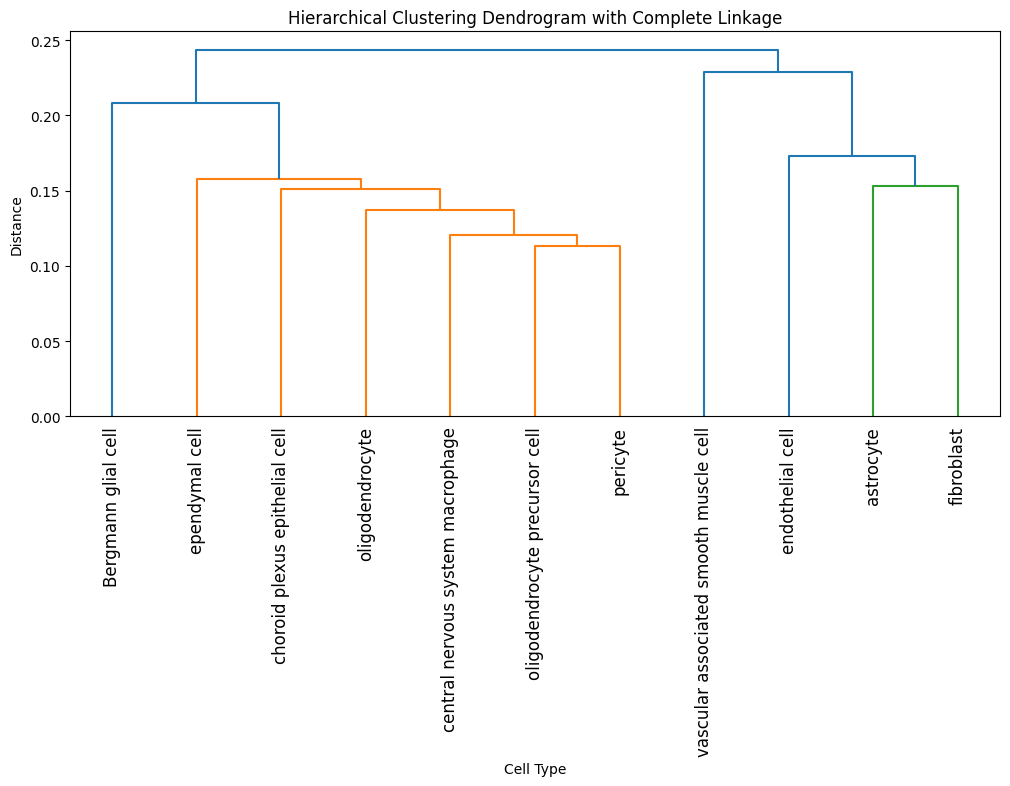

In [ ]:
dists_dim0_norm = dists_dim0 / np.linalg.norm(dists_dim0, keepdims=True)
dists_dim1_norm = dists_dim1 / np.linalg.norm(dists_dim1, keepdims=True)

dists_combine = dists_dim0_norm + dists_dim1_norm

# dendrogram with 0-dim + 1-dim homology
plot_dendrogram(dists_combine, method='average')
plot_dendrogram(dists_combine, method='single')
plot_dendrogram(dists_combine, method='complete')

In [ ]:
dists_combine = bottleneck_dist_mtrx(dgms, cell_types, dim='both')

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7e8d3e312680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1147, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# dendrogram with 0-dim + 1-dim homology
plot_dendrogram(dists_combine, method='average')
plot_dendrogram(dists_combine, method='single')
plot_dendrogram(dists_combine, method='complete')

## Persistence Image with Pearson (Finished)

### dgms

In [ ]:
dgms = ds2dgm_multi(ds, cell_types, method='pearson', reduce=True, plot=False, dim_red=True)

  0%|          | 0/3 [00:00<?, ?it/s]

Processing cell type fibroblast.
----dataframe
----distance
----diagram
Processing cell type astrocyte.
----dataframe
----distance
----diagram
Processing cell type ependymal cell.
----dataframe
----distance
----diagram


### images, p_norms(distance), dendrograms

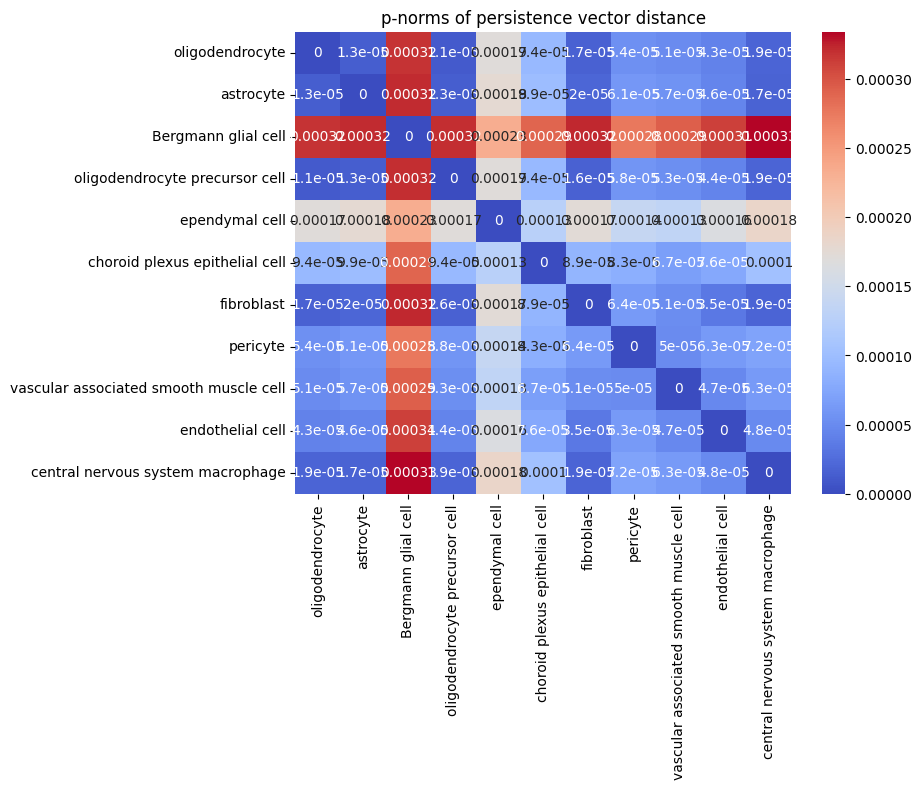

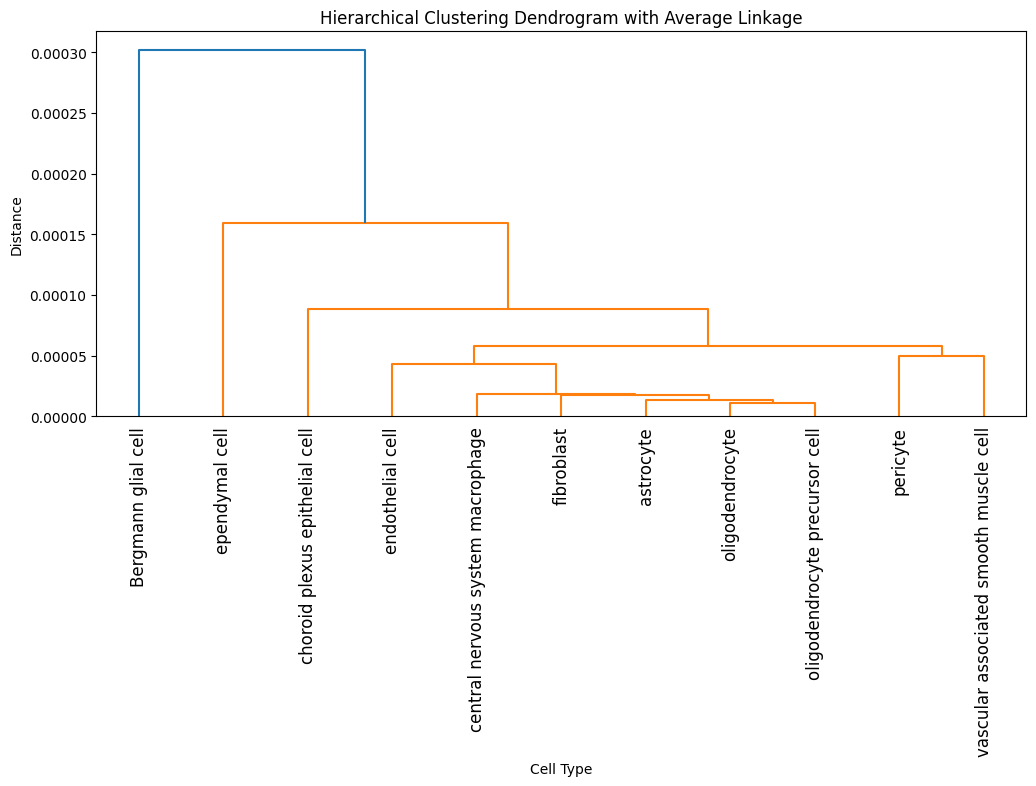

In [ ]:
imgs, valid_types = persistence_img_resize(dgms, cell_types, new_shape=(10, 3), padding=True)
p_norms = persistence_img_norms(imgs, valid_types, p=2, plot=True);
plot_dendrogram(p_norms, valid_types, method='average')

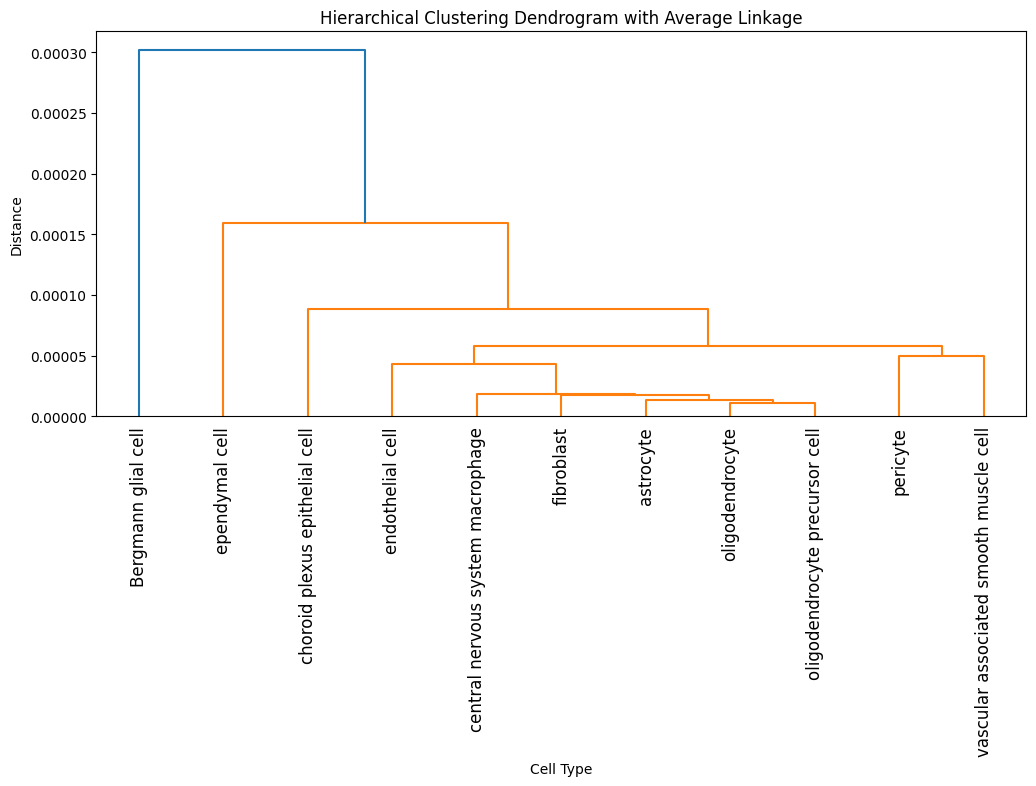

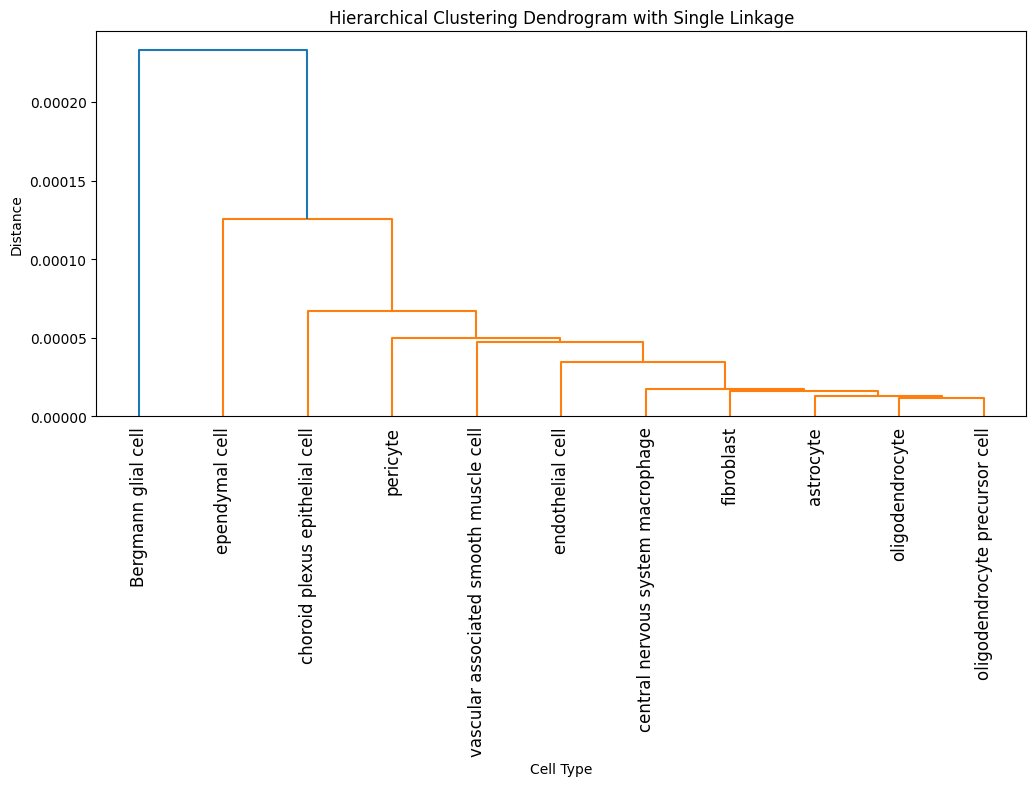

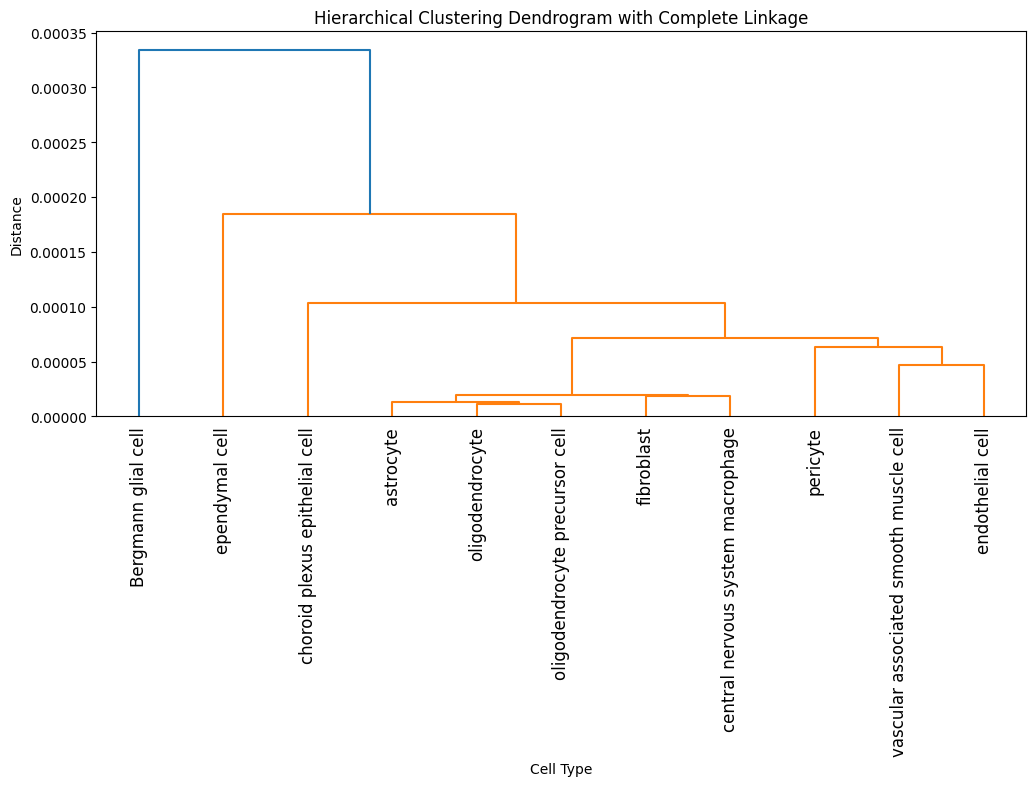

In [ ]:
plot_dendrogram(p_norms, valid_types, method='average')
plot_dendrogram(p_norms, valid_types, method='single')
plot_dendrogram(p_norms, valid_types, method='complete')

Oligodendrocyte Precursor Cell Not Applicable


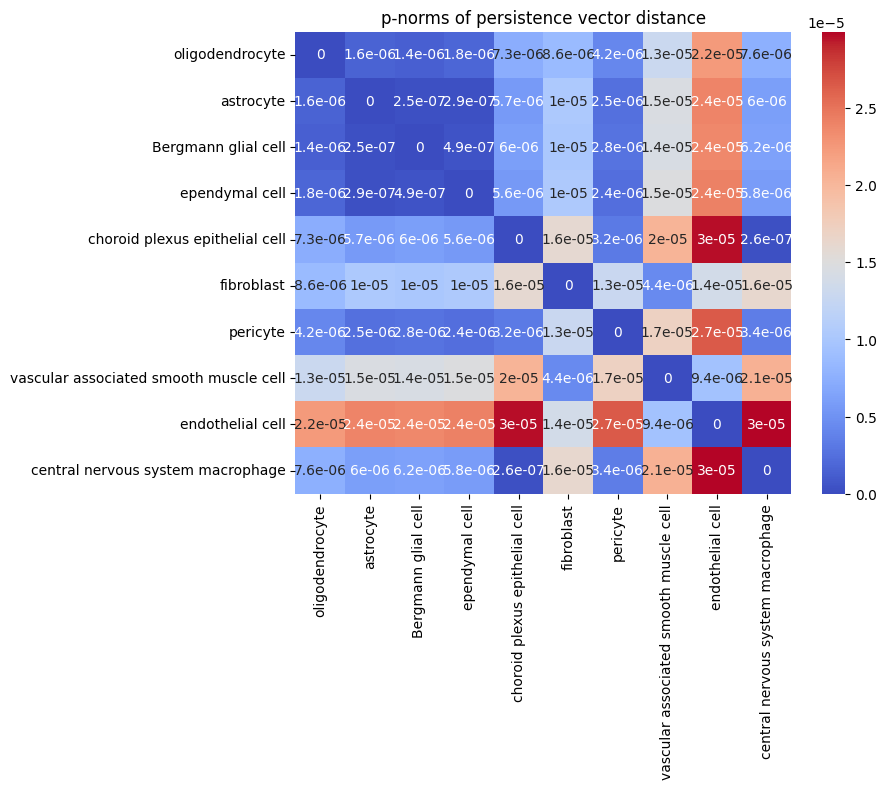

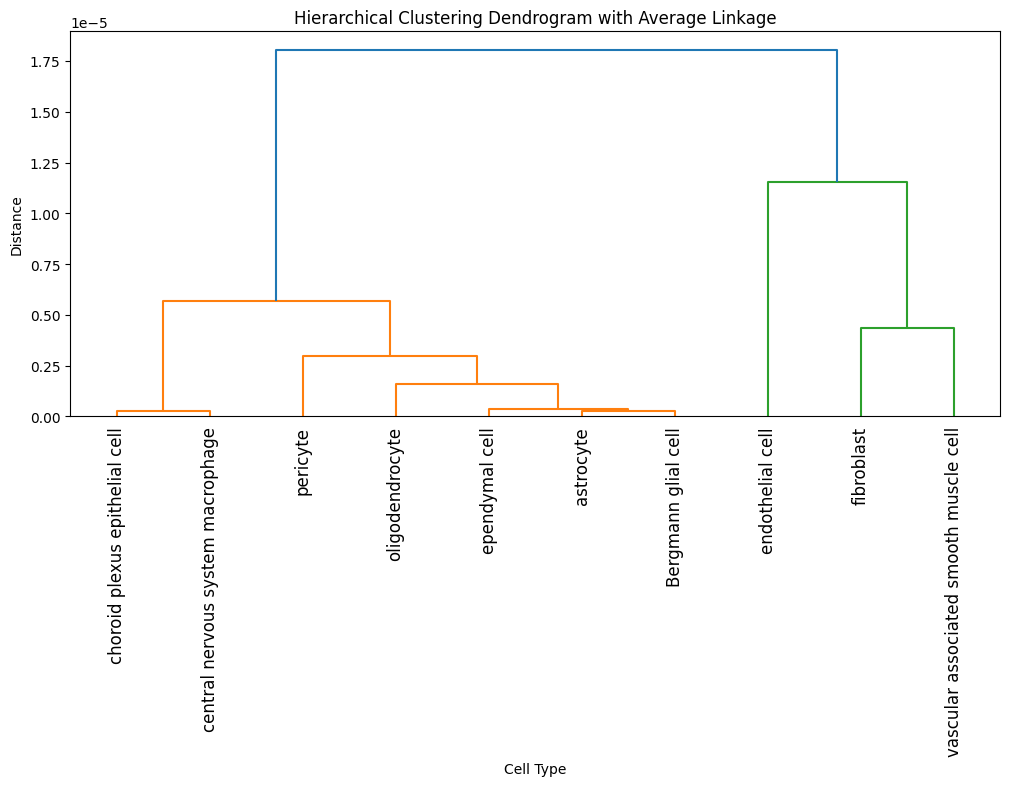

In [ ]:
# imgs, valid_types = persistence_img_resize(dgms, cell_types, new_shape=(10, 3), padding=False)
# p_norms = persistence_img_norms(imgs, valid_types, p=2, plot=True);
# plot_dendrogram(p_norms, valid_types, method='average')

# Hierachical Clustering with Euclidean Distance (😃)

## Bottleneck distance

### dgms

  0%|          | 0/11 [00:00<?, ?it/s]

Processing cell type oligodendrocyte.
----dataframe
----distance
(258, 236)
----diagram


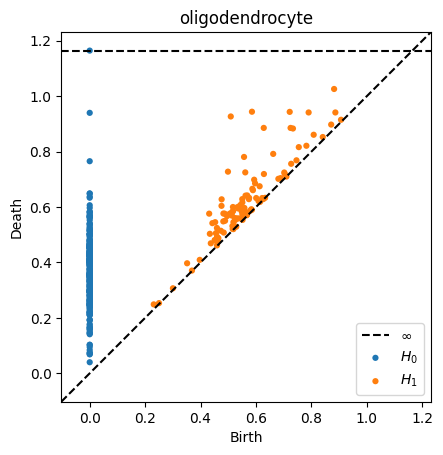

Processing cell type astrocyte.
----dataframe
----distance
(214, 196)
----diagram


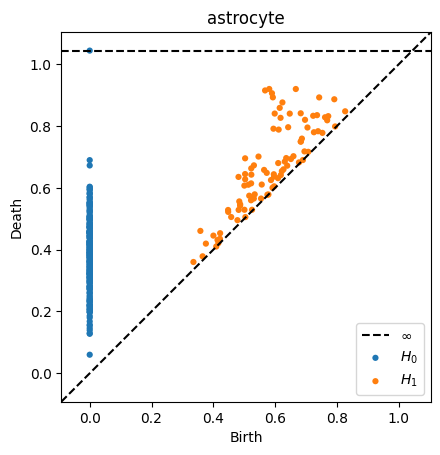

Processing cell type Bergmann glial cell.
----dataframe
----distance
(372, 325)
----diagram


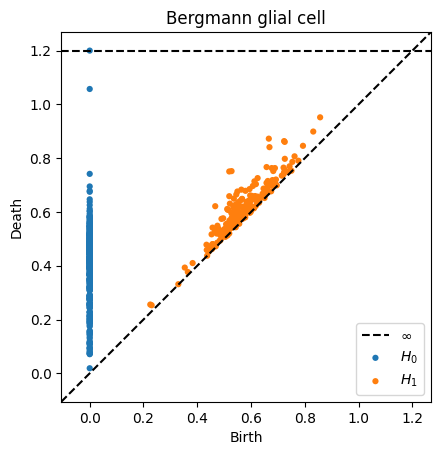

Processing cell type oligodendrocyte precursor cell.
----dataframe
----distance
(380, 338)
----diagram


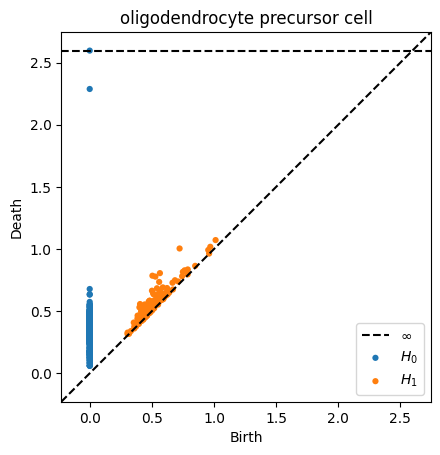

Processing cell type ependymal cell.
----dataframe
----distance
(333, 308)
----diagram


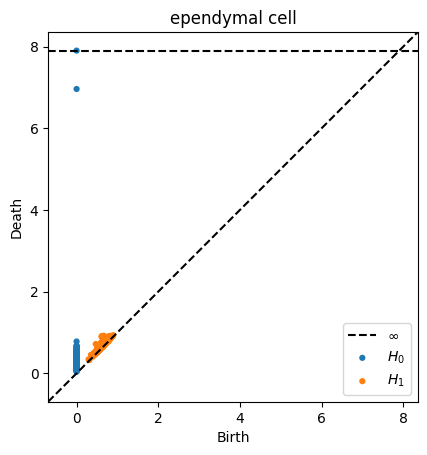

Processing cell type choroid plexus epithelial cell.
----dataframe
----distance
(1229, 1125)
----diagram


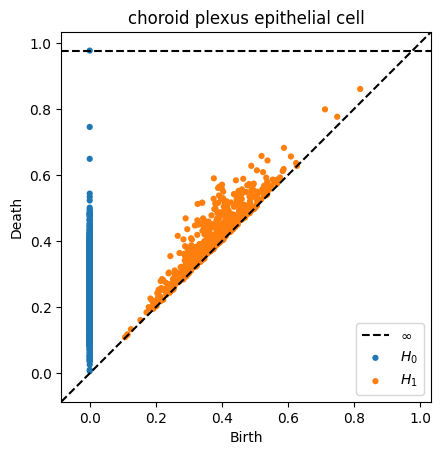

Processing cell type fibroblast.
----dataframe
----distance
(103, 96)
----diagram


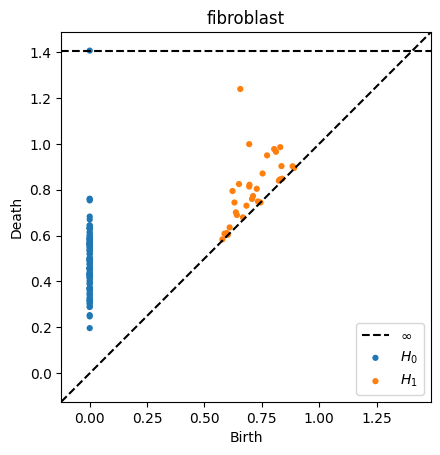

Processing cell type pericyte.
----dataframe
----distance
(122, 113)
----diagram


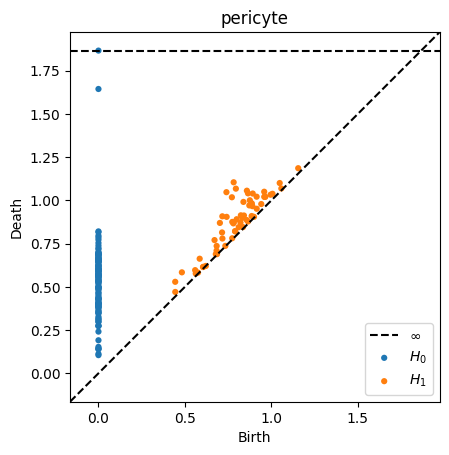

Processing cell type vascular associated smooth muscle cell.
----dataframe
----distance
(66, 63)
----diagram


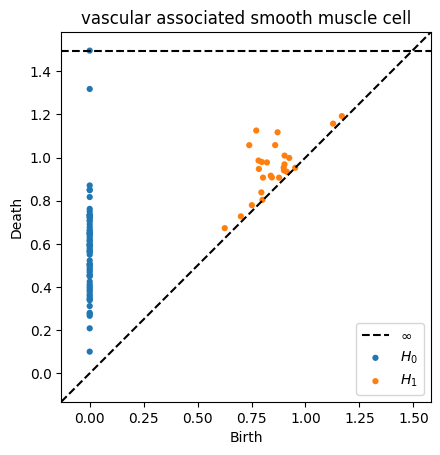

Processing cell type endothelial cell.
----dataframe
----distance
(123, 117)
----diagram


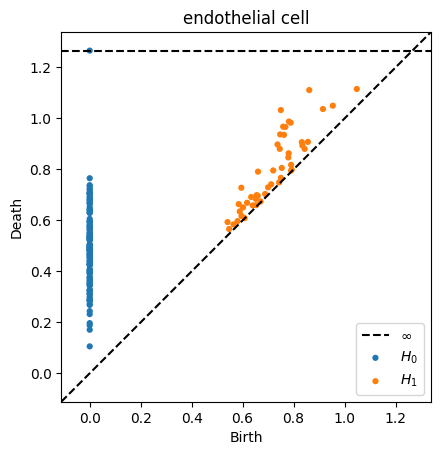

Processing cell type central nervous system macrophage.
----dataframe
----distance
(113, 104)
----diagram


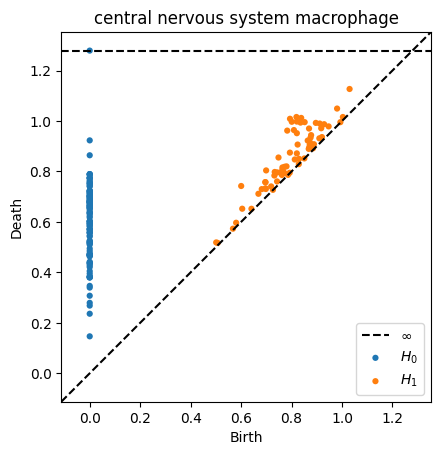

In [ ]:
### Hierachical clustering with pearson distance
# dgms = ds2dgm_multi(ds, cell_types, method='euclidean', reduce=True, plot=True, dim_red=True, maxdim=1)
dgms = ds2dgm_multi(ds, cell_types, method='euclidean', reduce=True, plot=True, dim_red=True, maxdim=1, preprocessing=True, variance=0.99)

### 1-dim distance

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

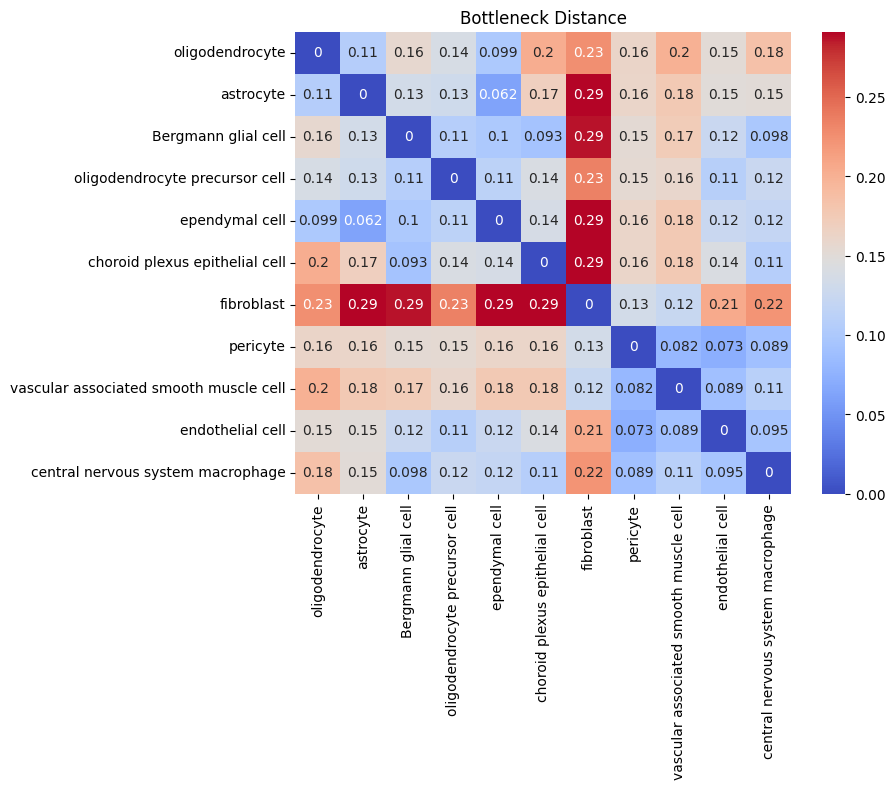

In [ ]:
### Distance calculated with 1-dim homology
dists_dim1 = bottleneck_dist_mtrx(dgms, cell_types, dim=1)

### dendrograms

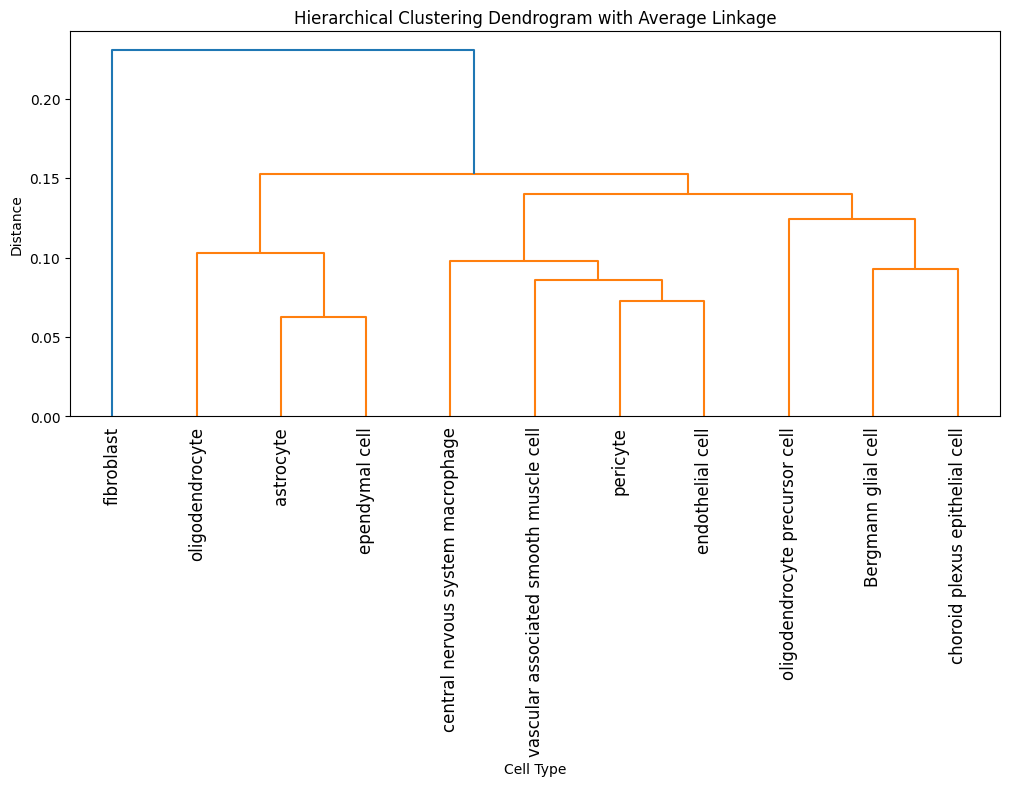

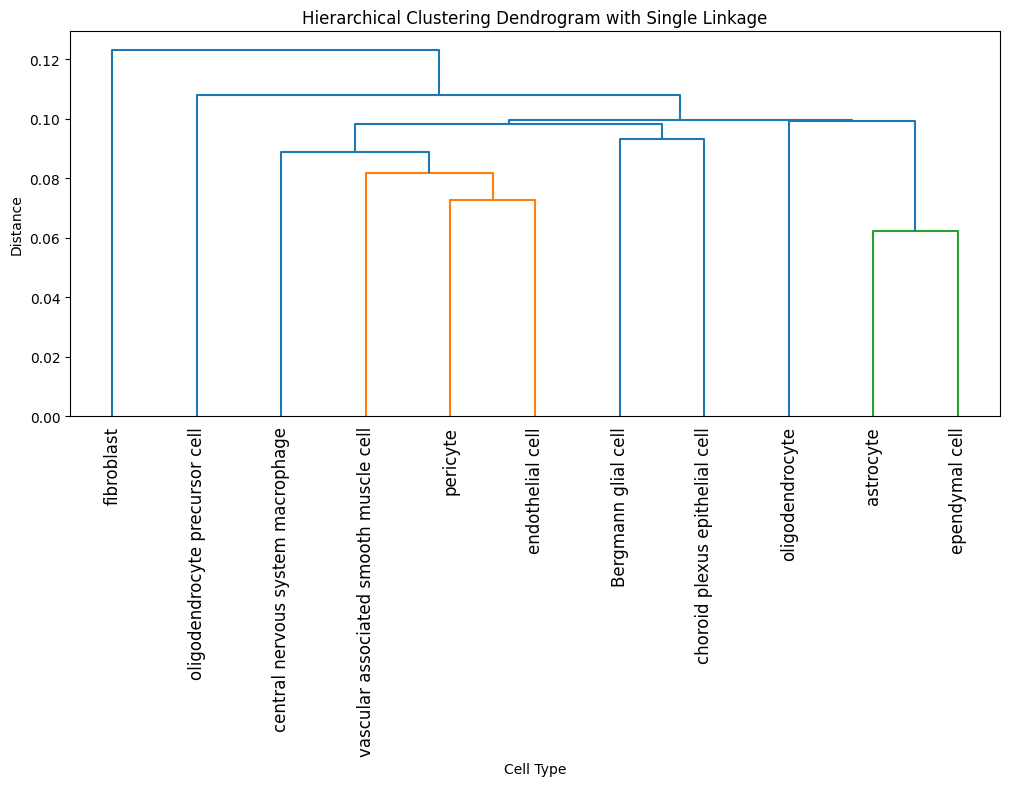

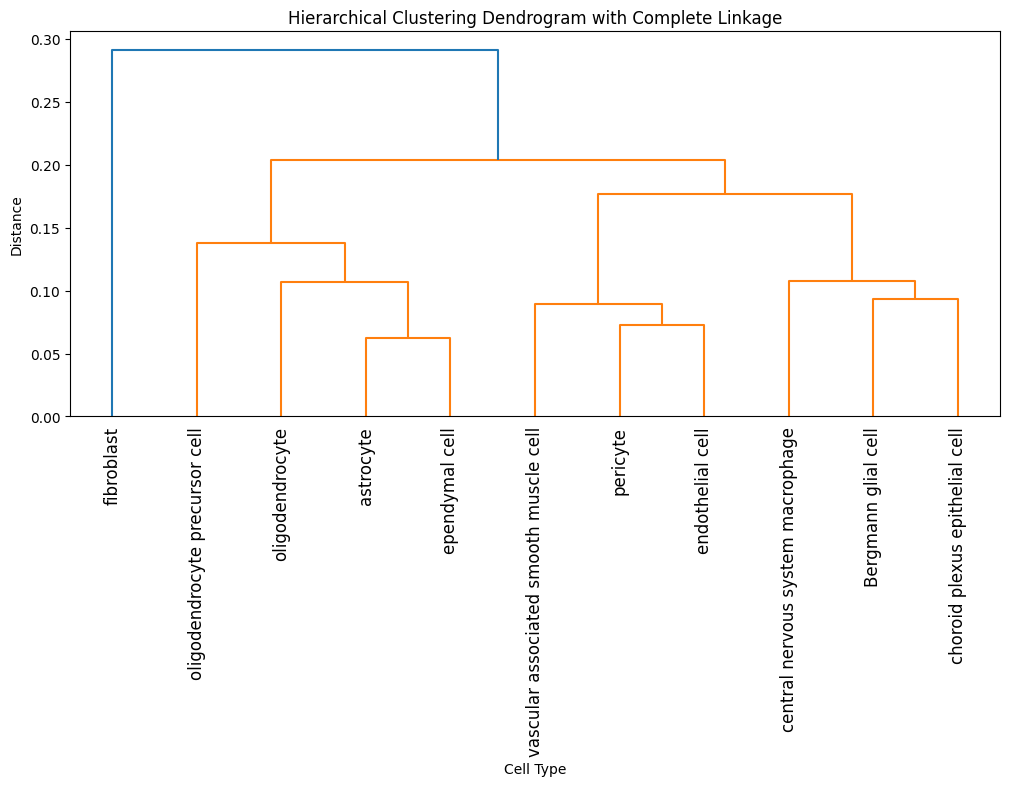

In [ ]:
# dendrogram with 1-dim homology
plot_dendrogram(dists_dim1, cell_types, method='average')
plot_dendrogram(dists_dim1, cell_types, method='single')
plot_dendrogram(dists_dim1, cell_types, method='complete')

## combined distance

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

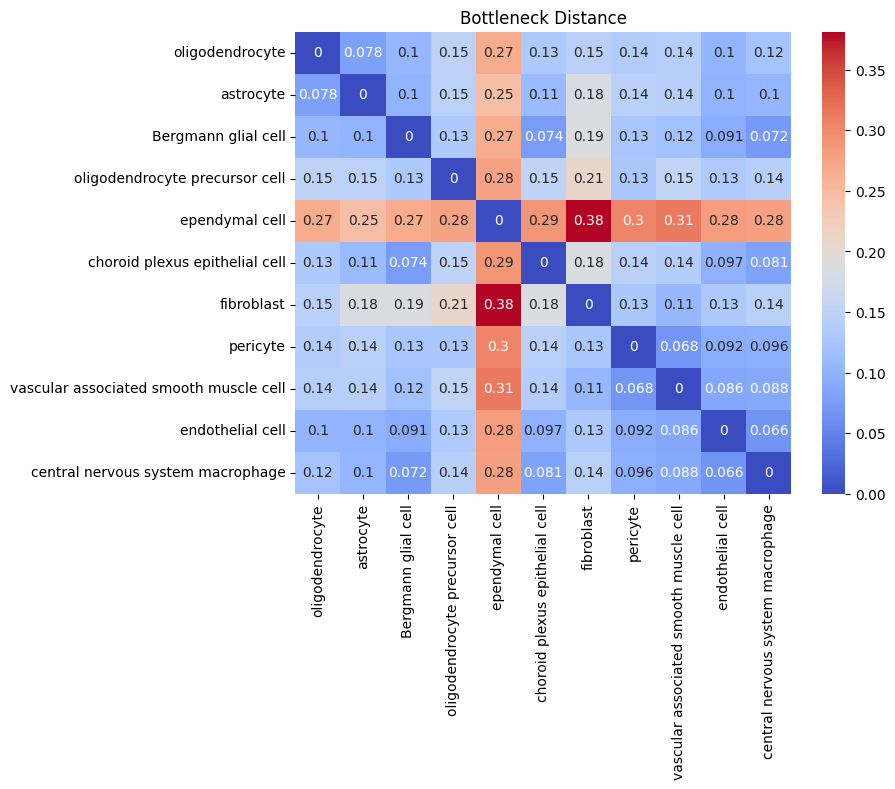

In [ ]:
### Distance calculated with 0&1-dim homology
dists_dim_both = bottleneck_dist_mtrx(dgms, cell_types, dim='both')

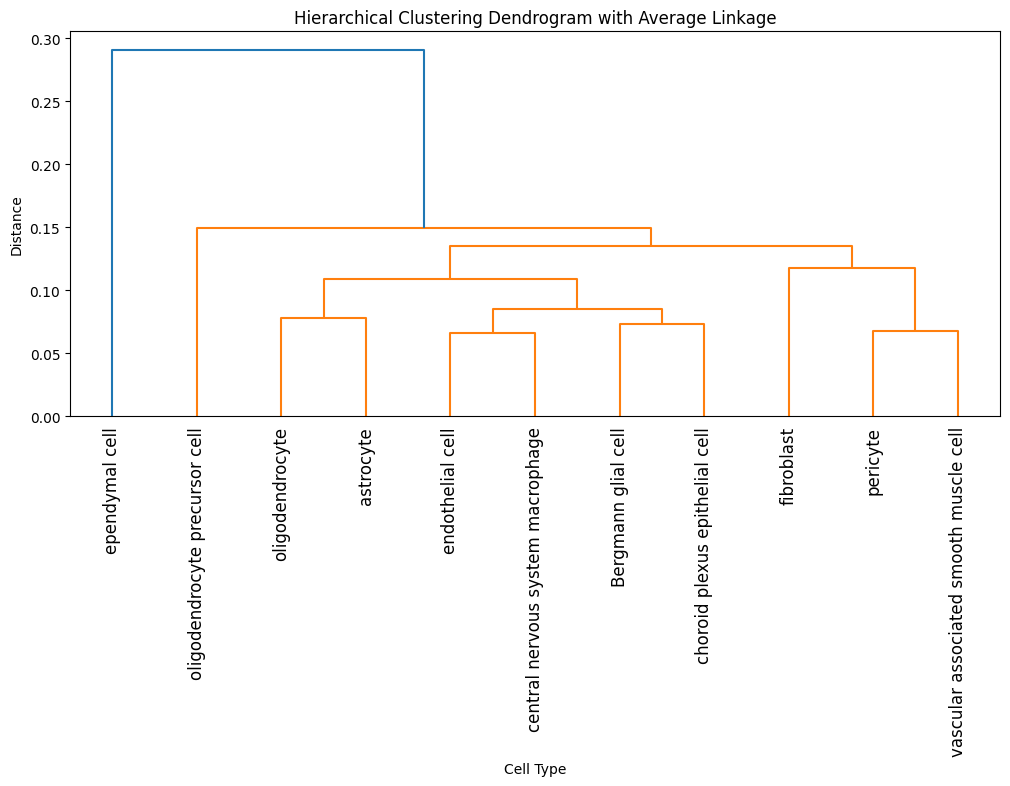

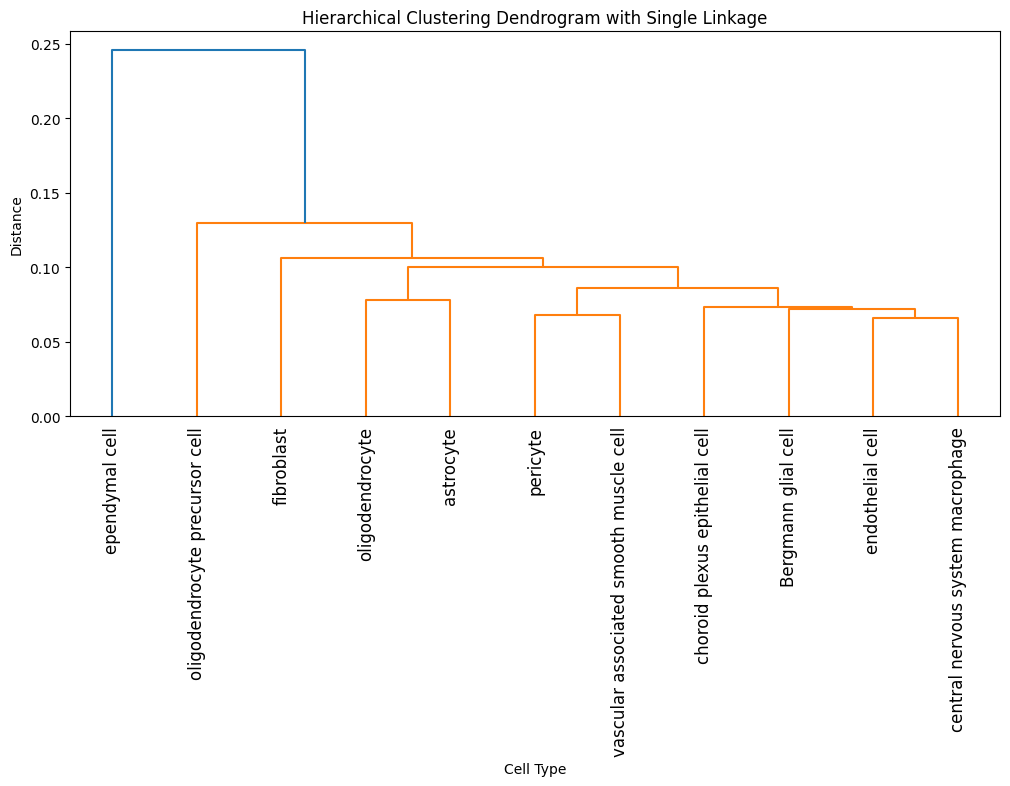

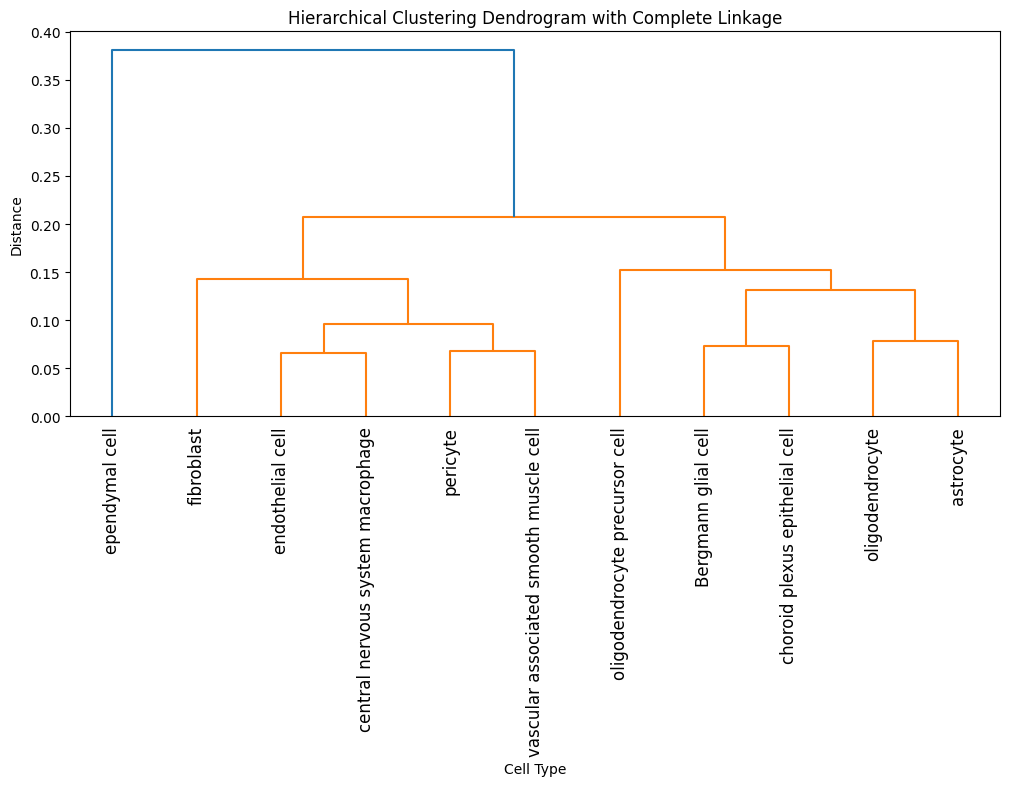

In [ ]:
# dendrogram with both-dim homology
plot_dendrogram(dists_dim_both, cell_types, method='average')
plot_dendrogram(dists_dim_both, cell_types, method='single')
plot_dendrogram(dists_dim_both, cell_types, method='complete')

## Persistance image (Need to remove small persistance pairs)

### dgms

  0%|          | 0/11 [00:00<?, ?it/s]

Processing cell type oligodendrocyte.
----dataframe
----distance
----diagram


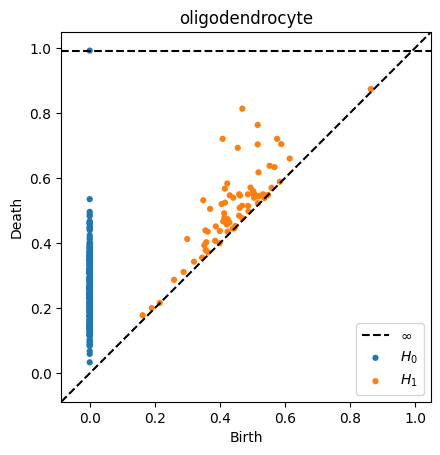

Processing cell type astrocyte.
----dataframe
----distance
----diagram


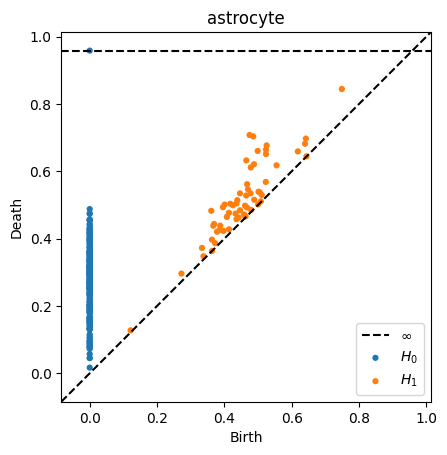

Processing cell type Bergmann glial cell.
----dataframe
----distance
----diagram


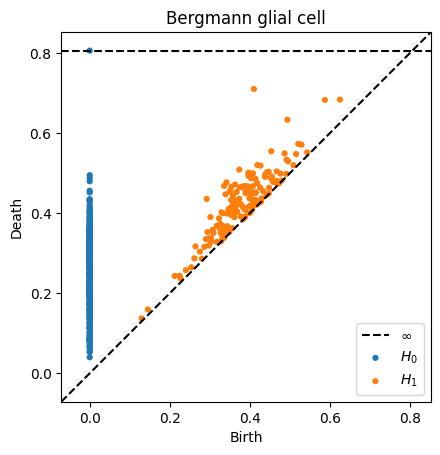

Processing cell type oligodendrocyte precursor cell.
----dataframe
----distance
----diagram


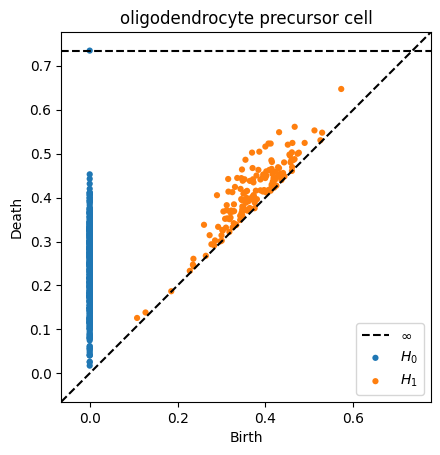

Processing cell type ependymal cell.
----dataframe
----distance
----diagram


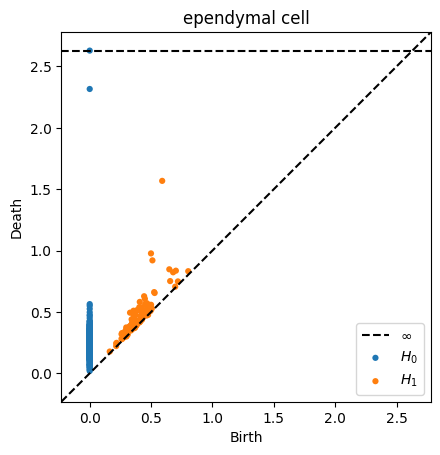

Processing cell type choroid plexus epithelial cell.
----dataframe
----distance
----diagram


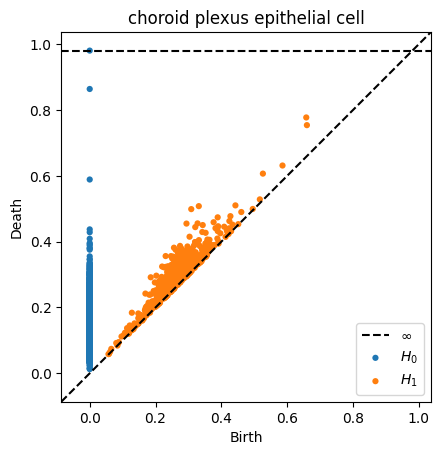

Processing cell type fibroblast.
----dataframe
----distance
----diagram


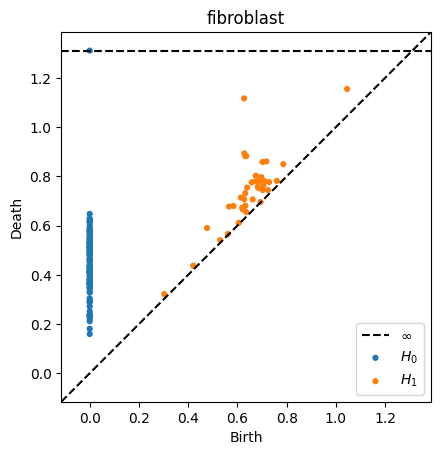

Processing cell type pericyte.
----dataframe
----distance
----diagram


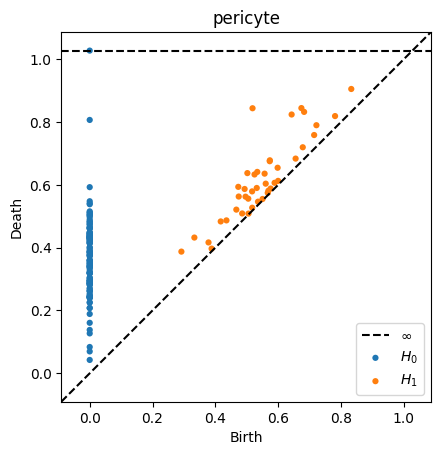

Processing cell type vascular associated smooth muscle cell.
----dataframe
----distance
----diagram


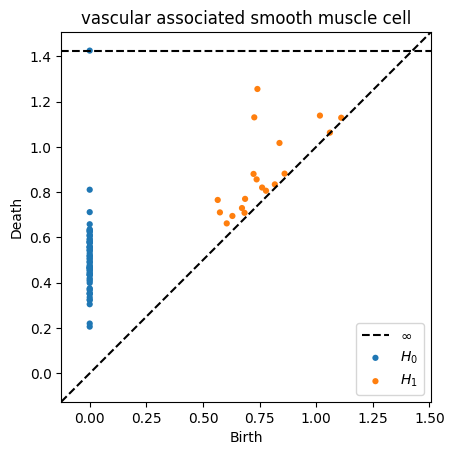

Processing cell type endothelial cell.
----dataframe
----distance
----diagram


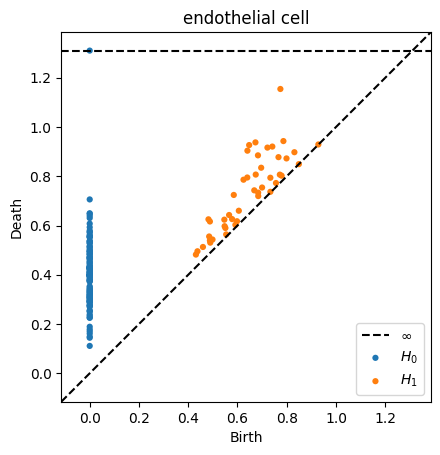

Processing cell type central nervous system macrophage.
----dataframe
----distance
----diagram


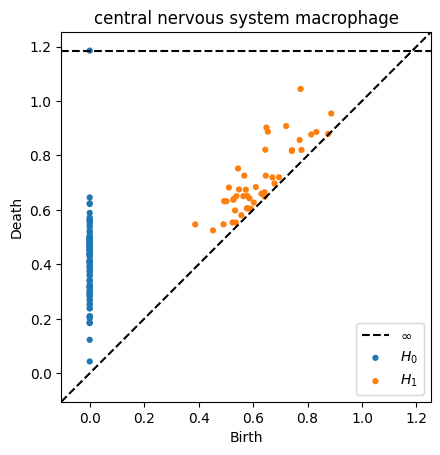

In [ ]:
### Hierachical clustering with euclidean distance
dgms = ds2dgm_multi(ds, cell_types, method='euclidean', reduce=True, plot=True, dim_red=True, maxdim=1)


### images

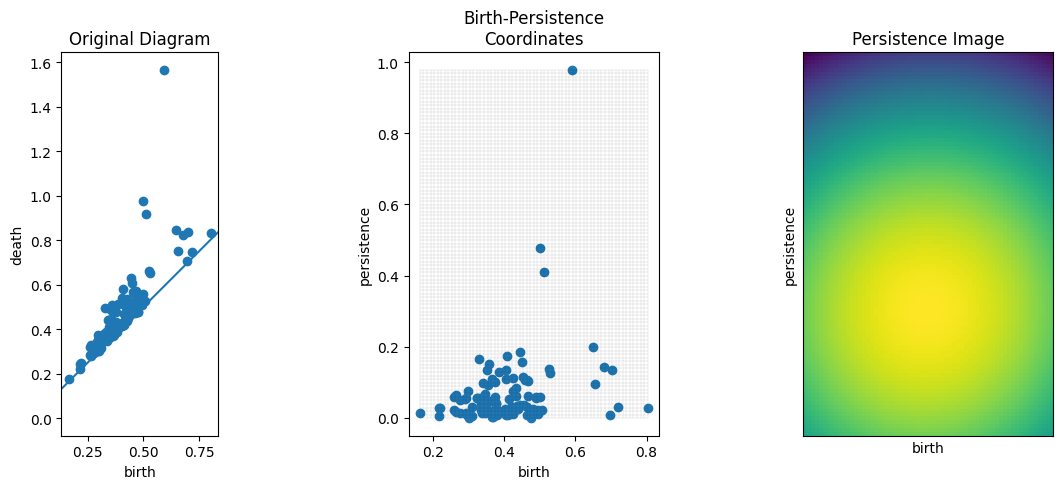

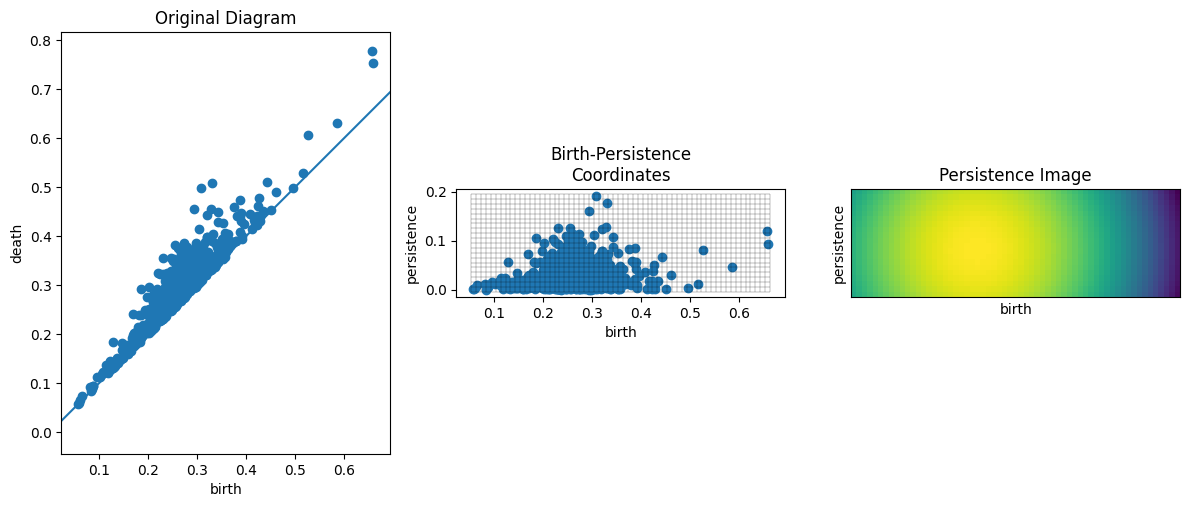

In [ ]:
# persistence_img(dgms[4], 'ependymal cell', plot=True, start=0.0)
imgs, valid_types = persistence_img_resize(dgms[4:6], ['ependymal cell', 'choroid plexus epithelial cell'],
                                           new_shape=(10, 3), padding=True, plot=True, start= 0.03, end=1.0)


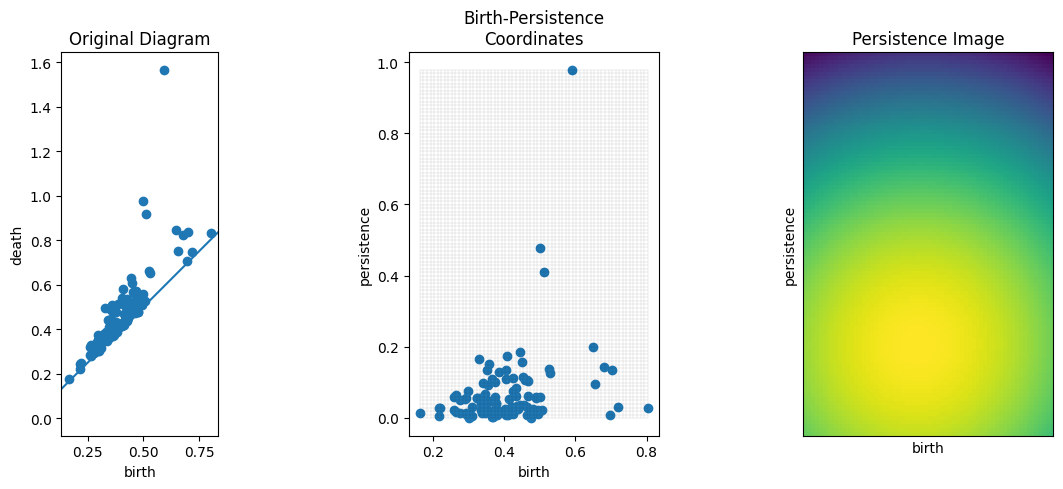

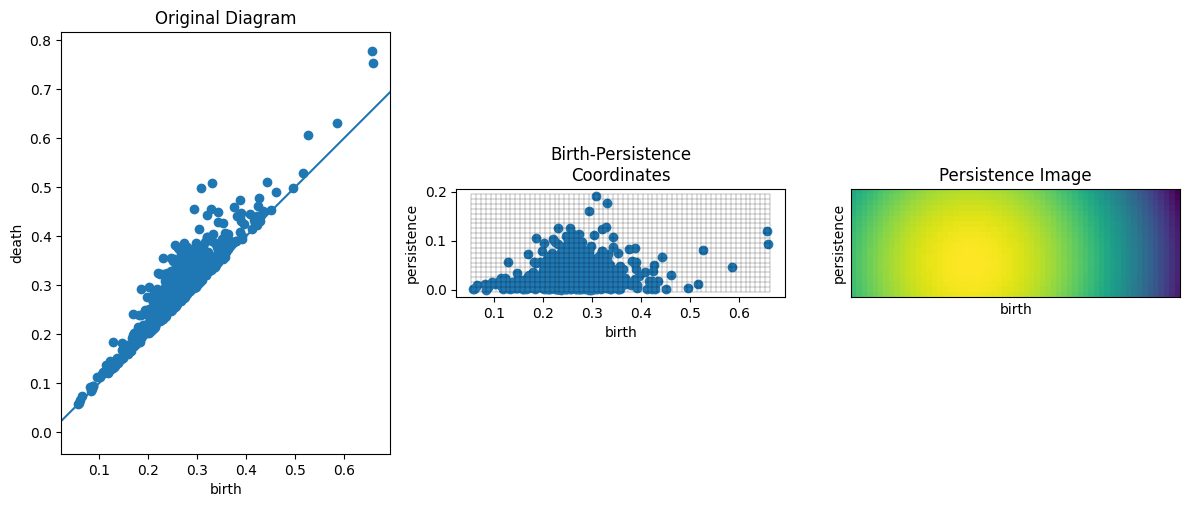

In [ ]:
# persistence_img(dgms[4], 'ependymal cell', plot=True, start=0.0)
imgs, valid_types = persistence_img_resize(dgms[4:6], ['ependymal cell', 'choroid plexus epithelial cell'],
                                           new_shape=(10, 3), padding=True, plot=True, start=0.0, end=10.0)


### dendrograms

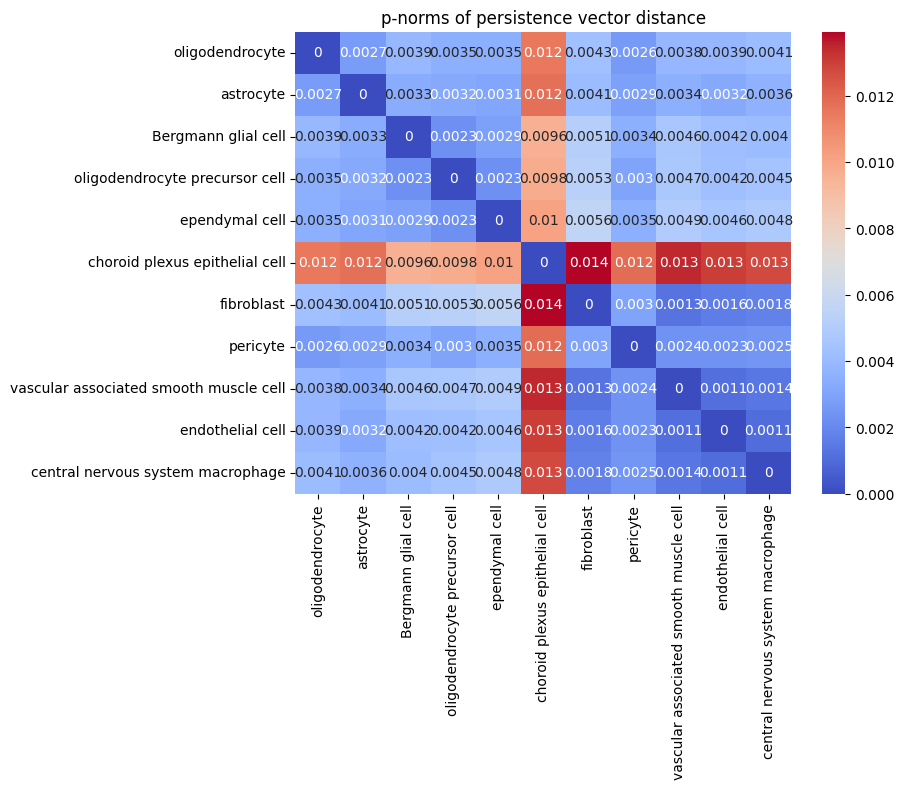

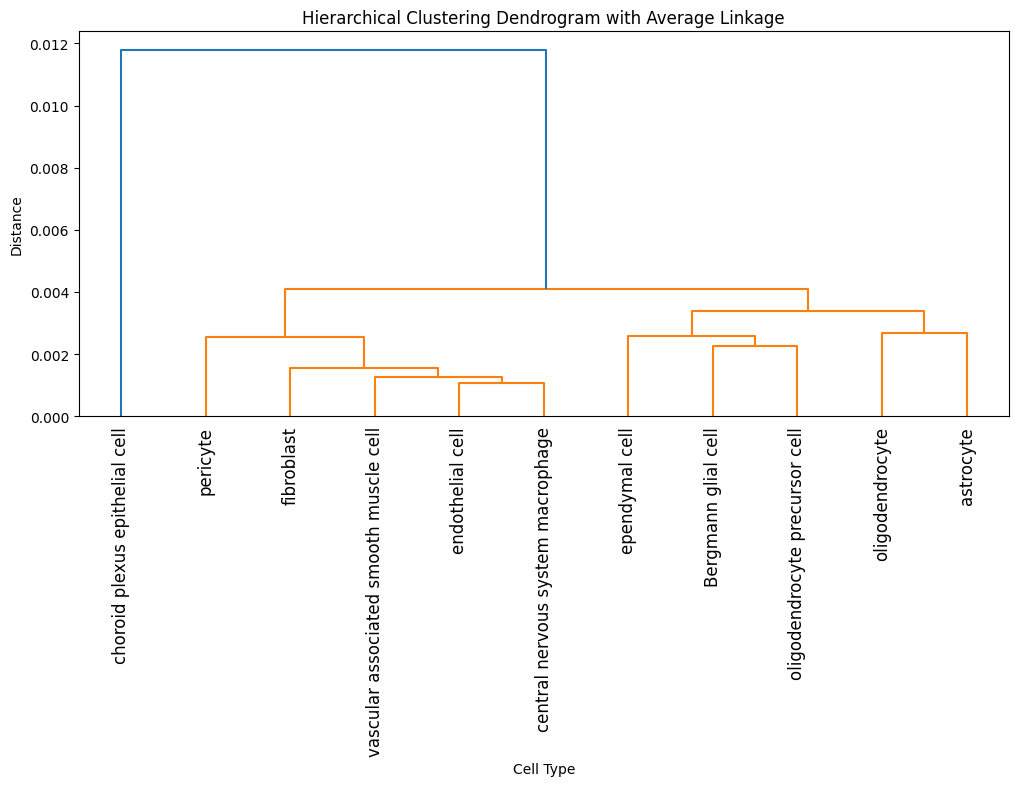

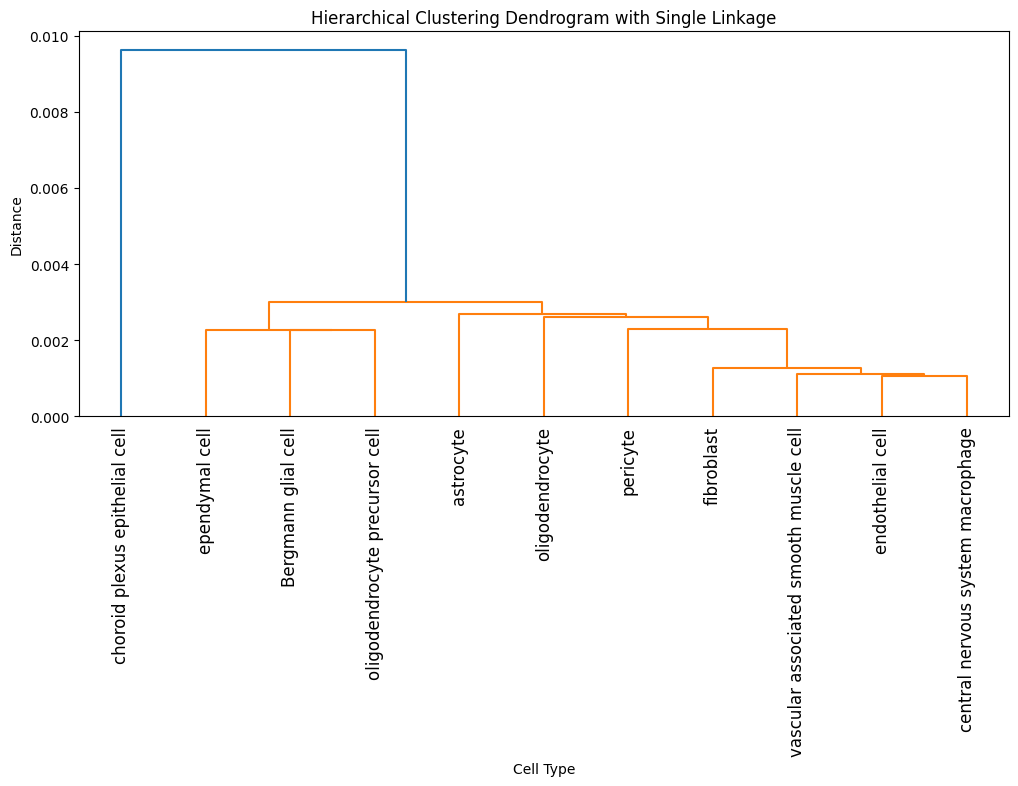

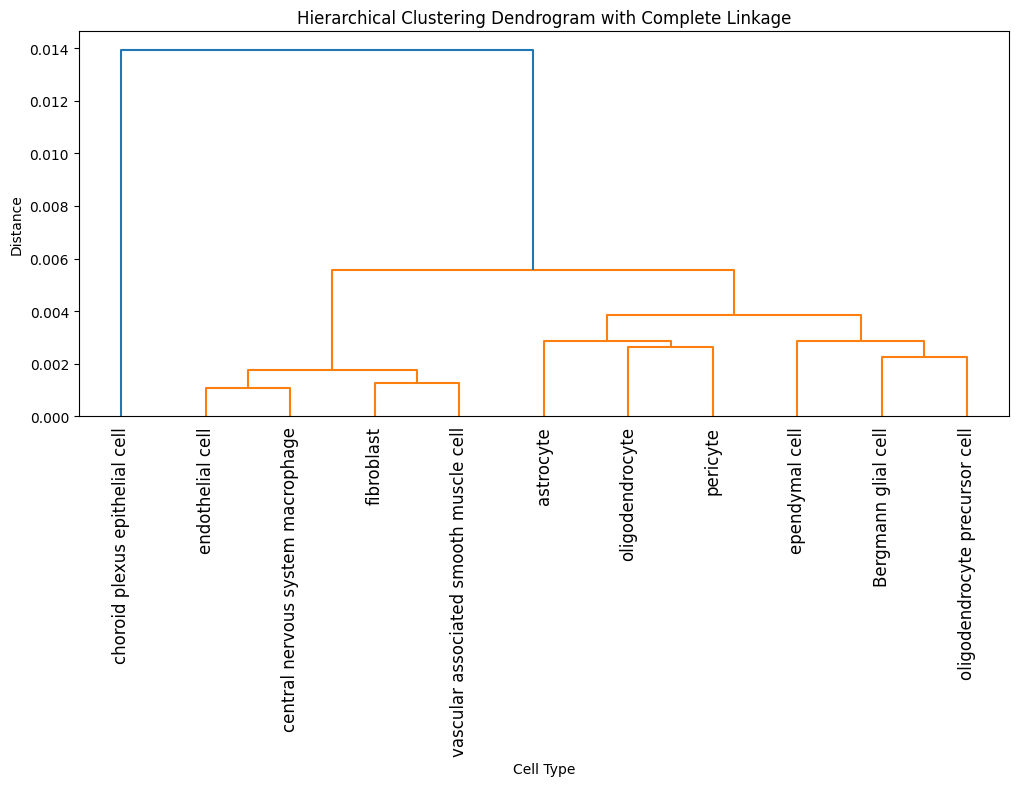

In [ ]:
### With persistence Image instead of bottleneck & remove small persistance
imgs, valid_types = persistence_img_resize(dgms, cell_types, new_shape=(10, 3), padding=True, end=1.0)
p_norms = persistence_img_norms(imgs, valid_types, p=2, plot=True);
plot_dendrogram(p_norms, valid_types, method='average')
plot_dendrogram(p_norms, valid_types, method='single')
plot_dendrogram(p_norms, valid_types, method='complete')

## HC with Euclidean - PCA before UMAP


### dgms

  0%|          | 0/11 [00:00<?, ?it/s]

Processing cell type oligodendrocyte.
----dataframe
----distance
----diagram


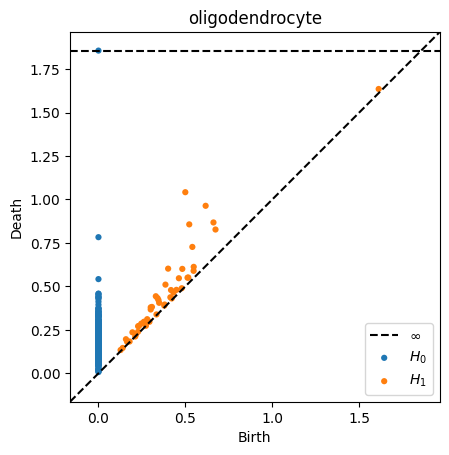

Processing cell type astrocyte.
----dataframe
----distance
----diagram


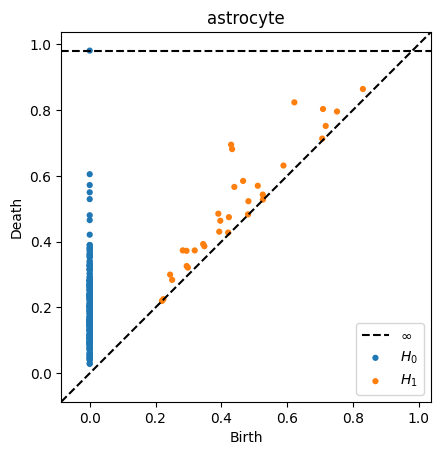

Processing cell type Bergmann glial cell.
----dataframe
----distance
----diagram


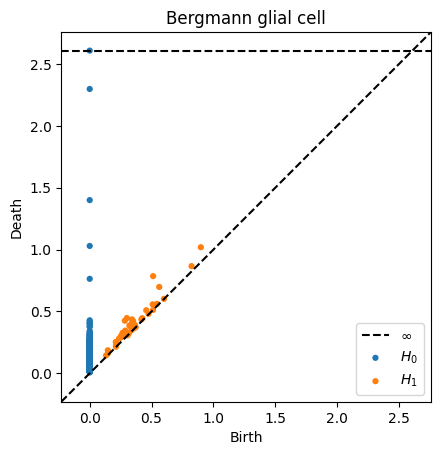

Processing cell type oligodendrocyte precursor cell.
----dataframe
----distance
----diagram


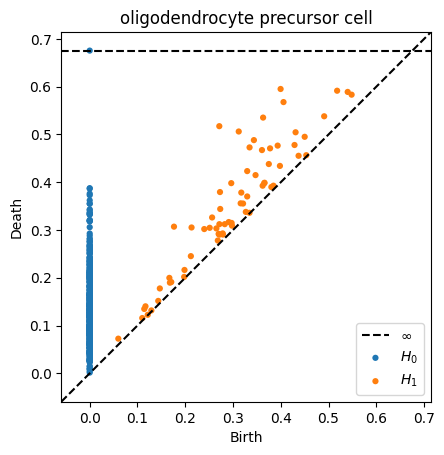

Processing cell type ependymal cell.
----dataframe
----distance
----diagram


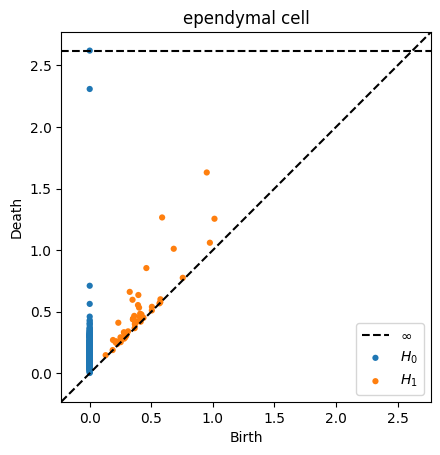

Processing cell type choroid plexus epithelial cell.
----dataframe
----distance
----diagram


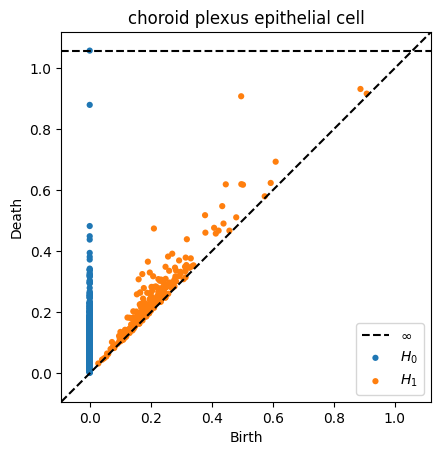

Processing cell type fibroblast.
----dataframe
----distance
----diagram


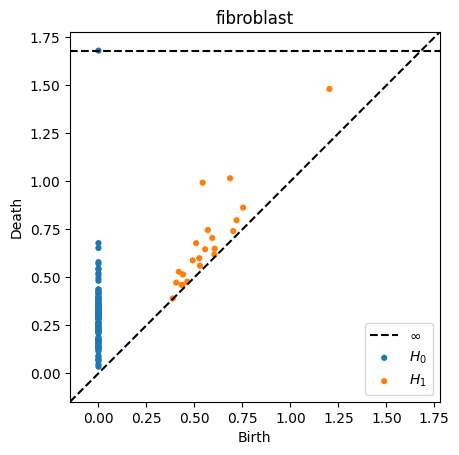

Processing cell type pericyte.
----dataframe
----distance
----diagram


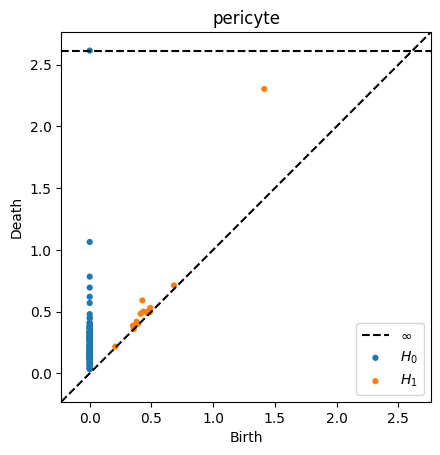

Processing cell type vascular associated smooth muscle cell.
----dataframe
----distance
----diagram


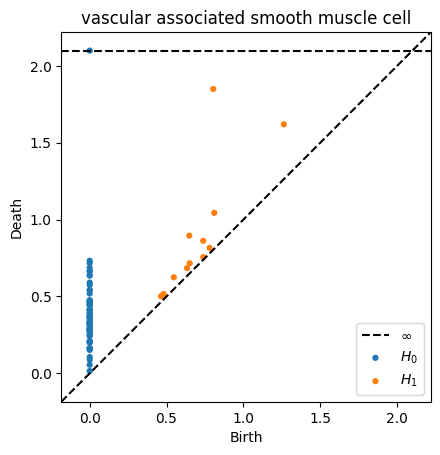

Processing cell type endothelial cell.
----dataframe
----distance
----diagram


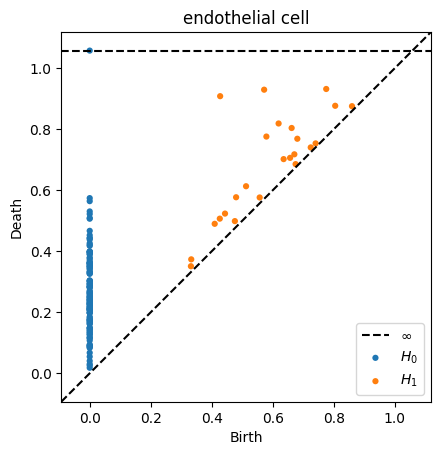

Processing cell type central nervous system macrophage.
----dataframe
----distance
----diagram


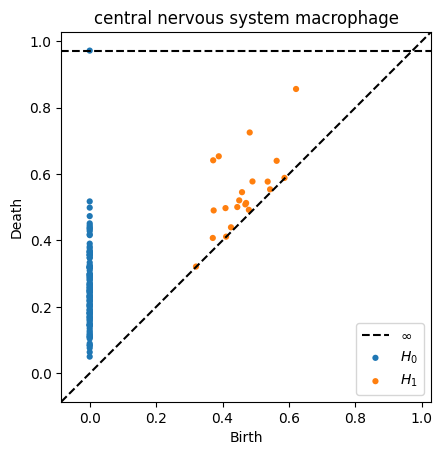

In [ ]:
### Hierachical clustering with pearson distance
dgms = ds2dgm_multi(ds, cell_types, method='euclidean', reduce=True, plot=True, dim_red=True, maxdim=1, preprocessing=True, variance=0.98)

### 1-dim distance

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

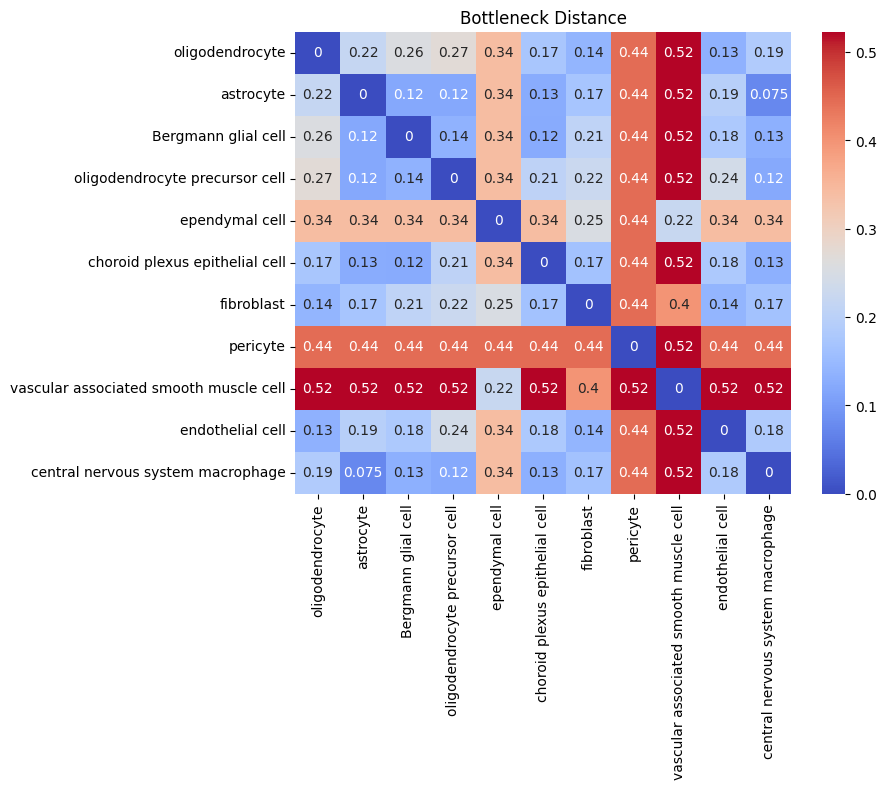

In [ ]:
### Distance calculated with 1-dim homology
dists_dim1 = bottleneck_dist_mtrx(dgms, cell_types, dim=1)

### dendrogram

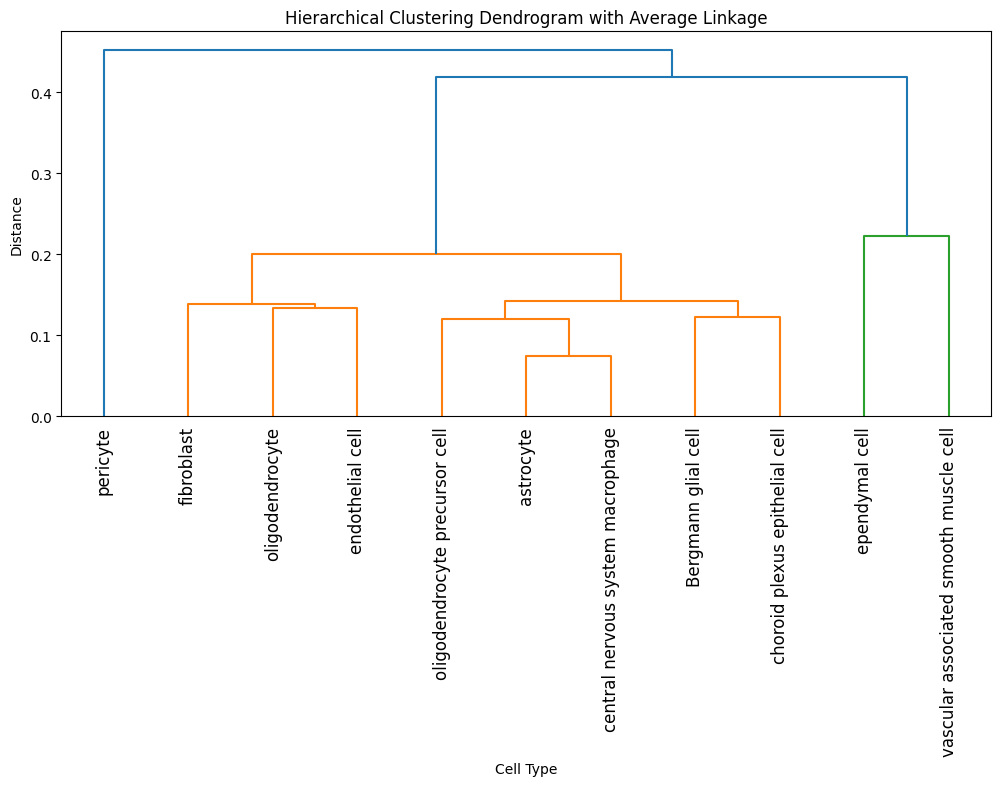

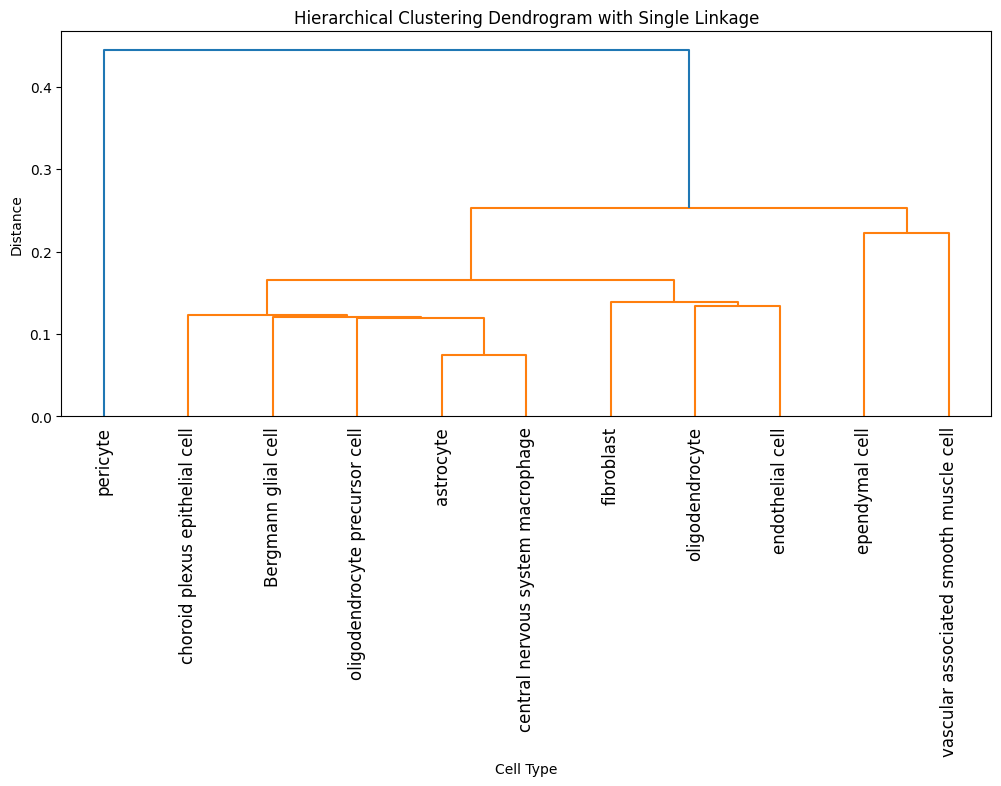

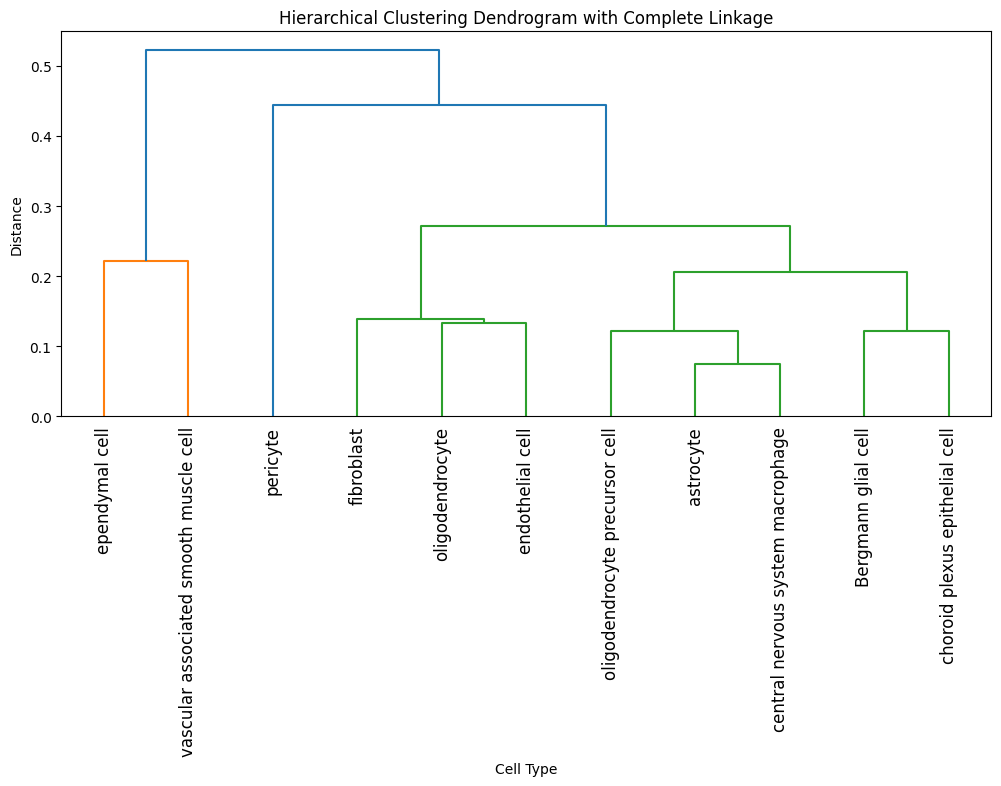

In [ ]:
# dendrogram with 1-dim homology
plot_dendrogram(dists_dim1, cell_types, method='average')
plot_dendrogram(dists_dim1, cell_types, method='single')
plot_dendrogram(dists_dim1, cell_types, method='complete')

# Mapper (WIP)

In [ ]:
df_all = []
for cell_type in cell_types:
  df = cell_df(ds, cell_type)
  df_all.append(df[:1000])
  del df

df_all = pd.concat(df_all).fillna(0, inplace = False)

In [ ]:
reducer = umap.UMAP(n_neighbors=15, n_components=15, metric='euclidean')

# Fit the model and transform the data
df_reduced= reducer.fit_transform(df_all.values)

In [ ]:
y = []
for cell_type in cell_types[:3]:
  for i in np.arange(5000):
    y.append(cell_type)

0.18500640450568104


<Figure size 500x500 with 0 Axes>

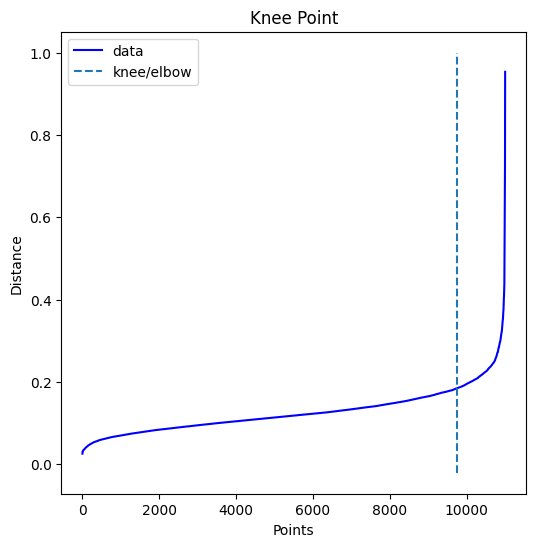

In [ ]:
# parameter tuning for eps
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(df_reduced)
distances, indices = neighbors.kneighbors(df_reduced)
distances = np.sort(distances[:,10], axis=0)
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
plt.rcParams.update({"text.usetex": False})
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(distances[knee.knee])

In [ ]:
filter_func = Eccentricity(exponent = 1)
cover = CubicalCover(n_intervals=20, overlap_frac=0.3)
# clusterer = FirstSimpleGap()
clusterer = DBSCAN(eps=distances[knee.knee])

pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=1,
)

fig = plot_static_mapper_graph(pipe, df_reduced)
fig.show(config={'scrollZoom': True})

In [ ]:
# Define filter function – can be any scikit-learn transformer
filter_func = Projection(columns=[0, 1])
# Define cover
cover = CubicalCover(n_intervals=10, overlap_frac=0.3)
# Choose clustering algorithm – default is DBSCAN
# clusterer = DBSCAN()
clusterer = FirstSimpleGap()

# Configure parallelism of clustering step
n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

In [ ]:
df_all

ENSG00000001629  ENSG00000005893  ENSG00000011426  \
CellID                                                                         
10X362_3:TCAGTGAGTATTGACC             16.0              1.0              6.0   
10X362_5:TCCGTGTGTGAAAGTT              3.0              0.0              5.0   
10X362_5:CACGGGTAGAGCAGAA              5.0              1.0              2.0   
10X362_5:GATTCTTGTATGTCAC             18.0              6.0             15.0   
10X362_6:AGGACTTGTATCCTTT             13.0              3.0              9.0   
...                                    ...              ...              ...   
10X194_8:GAAATGAGTTCGGCTG              0.0              0.0              0.0   
10X350_4:TTTACCATCGCACGAC              0.0              0.0              0.0   
10X225_1:AGAAGCGTCCATATGG              0.0              0.0              0.0   
10X221_5:TTGAACGCAGCCTTCT              0.0              0.0              0.0   
10X385_3:CTACCCAGTGGCGCTT              0.0              0.0              0.0   

                           ENSG00000012983  ENSG00000021645  ENSG00000033170  \
CellID                                                                         
10X362_3:TCAGTGAGTATTGACC             17.0             51.0             14.0   
10X362_5:TCCGTGTGTGAAAGTT              9.0             45.0              5.0   
10X362_5:CACGGGTAGAGCAGAA              8.0             38.0             10.0   
10X362_5:GATTCTTGTATGTCAC             21.0             29.0             15.0   
10X362_6:AGGACTTGTATCCTTT             20.0            161.0             20.0   
...                                    ...              ...              ...   
10X194_8:GAAATGAGTTCGGCTG              0.0              0.0              0.0   
10X350_4:TTTACCATCGCACGAC              0.0              0.0              0.0   
10X225_1:AGAAGCGTCCATATGG              0.0              0.0              0.0   
10X221_5:TTGAACGCAGCCTTCT              0.0              0.0              0.0   
10X385_3:CTACCCAGTGGCGCTT              0.0              0.0              0.0   

                           ENSG00000033327  ENSG00000039319  ENSG00000046653  \
CellID                                                                         
10X362_3:TCAGTGAGTATTGACC              9.0              5.0             19.0   
10X362_5:TCCGTGTGTGAAAGTT             11.0              4.0              1.0   
10X362_5:CACGGGTAGAGCAGAA              3.0              6.0             12.0   
10X362_5:GATTCTTGTATGTCAC             22.0             27.0            126.0   
10X362_6:AGGACTTGTATCCTTT              8.0              8.0              3.0   
...                                    ...              ...              ...   
10X194_8:GAAATGAGTTCGGCTG              0.0              0.0              0.0   
10X350_4:TTTACCATCGCACGAC             11.0              0.0              0.0   
10X225_1:AGAAGCGTCCATATGG              5.0              0.0              0.0   
10X221_5:TTGAACGCAGCCTTCT              0.0              0.0              0.0   
10X385_3:CTACCCAGTGGCGCTT              5.0              0.0              0.0   

                           ENSG00000047365  ...  ENSG00000169313  \
CellID                                      ...                    
10X362_3:TCAGTGAGTATTGACC             13.0  ...              0.0   
10X362_5:TCCGTGTGTGAAAGTT              3.0  ...              0.0   
10X362_5:CACGGGTAGAGCAGAA              5.0  ...              0.0   
10X362_5:GATTCTTGTATGTCAC             14.0  ...              0.0   
10X362_6:AGGACTTGTATCCTTT             12.0  ...              0.0   
...                                    ...  ...              ...   
10X194_8:GAAATGAGTTCGGCTG              0.0  ...              0.0   
10X350_4:TTTACCATCGCACGAC              0.0  ...              1.0   
10X225_1:AGAAGCGTCCATATGG              0.0  ...              0.0   
10X221_5:TTGAACGCAGCCTTCT              0.0  ...              2.0   
10X385_3:CTACCCAGTGGCGCTT              0.0  ...              0.0   

                   

In [ ]:
# Initialize UMAP
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean')

# Fit the model and transform the data
embedding = reducer.fit_transform(df_all)

# Convert the result into a DataFrame for easier plotting
embedding_df = pd.DataFrame(embedding, columns=['Component 1', 'Component 2'])


In [ ]:
# Plotting
plt.rcParams.update({"text.usetex": False})
plt.figure(figsize=(10, 7))
plt.scatter(embedding_df['Component 1'], embedding_df['Component 2'], s=100)
plt.title('UMAP projection of the Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()


In [ ]:
df_1 = cell_df(ds, 'oligodendrocyte precursor cell')
df_2 = cell_df(ds, 'fibroblast')
df_3 = cell_df(ds, 'vascular associated smooth muscle cell')

In [ ]:
df_4 = pd.concat([df_1, df_2, df_3]).fillna(0, inplace = False)
df_4

ENSG00000002746  ENSG00000005108  ENSG00000005810  \
CellID                                                                         
10X218_3:ATAGACCGTATCGGTT              4.0              2.0              2.0   
10X375_8:TACACCCGTTCGTACA              0.0              0.0              4.0   
10X318_5:ACTTAGGTCGCACGAC              0.0              2.0              1.0   
10X393_4:TCTCAGCCAGCGGTCT              1.0              0.0              2.0   
10X381_8:ATTCCCGTCACTACTT              0.0              0.0              0.0   
...                                    ...              ...              ...   
10X387_7:ACGGGTCCAGACAAGC              0.0              0.0              0.0   
10X360_1:CTGATCCGTATTCCTT              0.0              0.0              0.0   
10X360_2:AAGAACAGTTCCTTGC              0.0              0.0              0.0   
10X362_5:GAGGGTACATTGCAAC              0.0              0.0              0.0   
10X393_1:CCAATTTAGCCTTCTC              0.0              0.0              0.0   

                           ENSG00000009413  ENSG00000010810  ENSG00000012983  \
CellID                                                                         
10X218_3:ATAGACCGTATCGGTT              1.0              5.0              2.0   
10X375_8:TACACCCGTTCGTACA              3.0              5.0              4.0   
10X318_5:ACTTAGGTCGCACGAC              7.0              2.0              1.0   
10X393_4:TCTCAGCCAGCGGTCT              4.0              2.0              4.0   
10X381_8:ATTCCCGTCACTACTT              2.0              0.0              0.0   
...                                    ...              ...              ...   
10X387_7:ACGGGTCCAGACAAGC              0.0              0.0              0.0   
10X360_1:CTGATCCGTATTCCTT              0.0              0.0              0.0   
10X360_2:AAGAACAGTTCCTTGC              0.0              0.0              0.0   
10X362_5:GAGGGTACATTGCAAC              0.0              0.0              0.0   
10X393_1:CCAATTTAGCCTTCTC              0.0              0.0              0.0   

                           ENSG00000018236  ENSG00000020577  ENSG00000033122  \
CellID                                                                         
10X218_3:ATAGACCGTATCGGTT              5.0              5.0              3.0   
10X375_8:TACACCCGTTCGTACA              5.0              8.0              2.0   
10X318_5:ACTTAGGTCGCACGAC             10.0              0.0              8.0   
10X393_4:TCTCAGCCAGCGGTCT              4.0              4.0              1.0   
10X381_8:ATTCCCGTCACTACTT              1.0              0.0              3.0   
...                                    ...              ...              ...   
10X387_7:ACGGGTCCAGACAAGC              0.0              0.0              0.0   
10X360_1:CTGATCCGTATTCCTT              0.0              0.0              0.0   
10X360_2:AAGAACAGTTCCTTGC              0.0              0.0              0.0   
10X362_5:GAGGGTACATTGCAAC              0.0              0.0              0.0   
10X393_1:CCAATTTAGCCTTCTC              0.0              0.0              0.0   

                           ENSG00000038382  ...  ENSG00000182732  \
CellID                                      ...                    
10X218_3:ATAGACCGTATCGGTT              4.0  ...              0.0   
10X375_8:TACACCCGTTCGTACA              4.0  ...              0.0   
10X318_5:ACTTAGGTCGCACGAC              4.0  ...              0.0   
10X393_4:TCTCAGCCAGCGGTCT              1.0  ...              0.0   
10X381_8:ATTCCCGTCACTACTT              0.0  ...              0.0   
...                                    ...  ...              ...   
10X387_7:ACGGGTCCAGACAAGC              0.0  ...              1.0   
10X360_1:CTGATCCGTATTCCTT              0.0  ...              3.0   
10X360_2:AAGAACAGTTCCTTGC              0.0  ...              2.0   
10X362_5:GAGGGTACATTGCAAC              0.0  ...              0.0   
10X393_1:CCAATTTAGCCTTCTC              0.0  ...              2.0   

                   

# UMAP

In [ ]:
# Initialize UMAP
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean')

# Fit the model and transform the data
embedding = reducer.fit_transform(pd.concat([df_1, df_2]).fillna(0, inplace = False))

# Convert the result into a DataFrame for easier plotting
embedding_df = pd.DataFrame(embedding, columns=['Component 1', 'Component 2'])


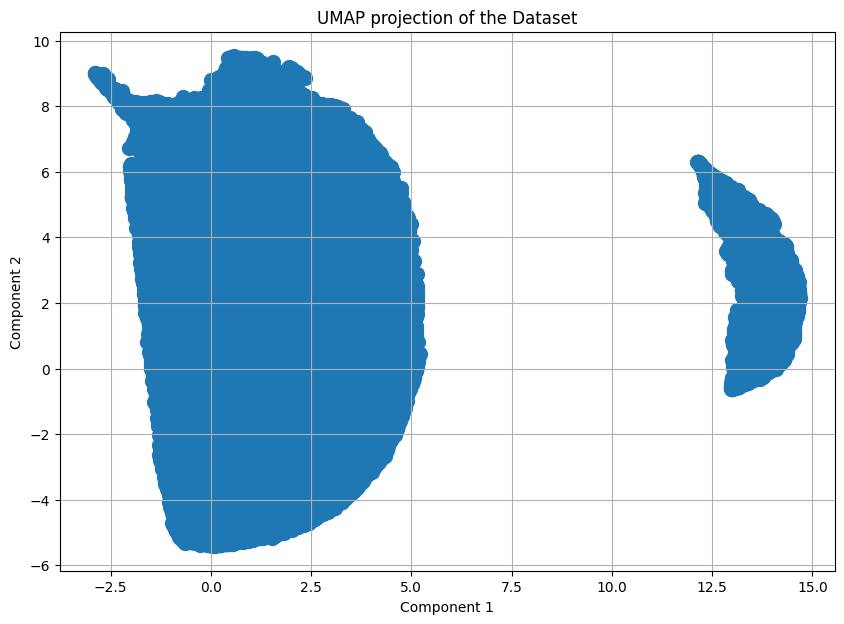

In [ ]:
# Plotting
plt.rcParams.update({"text.usetex": False})
plt.figure(figsize=(10, 7))
plt.scatter(embedding_df['Component 1'], embedding_df['Component 2'], s=100)
plt.title('UMAP projection of the Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()


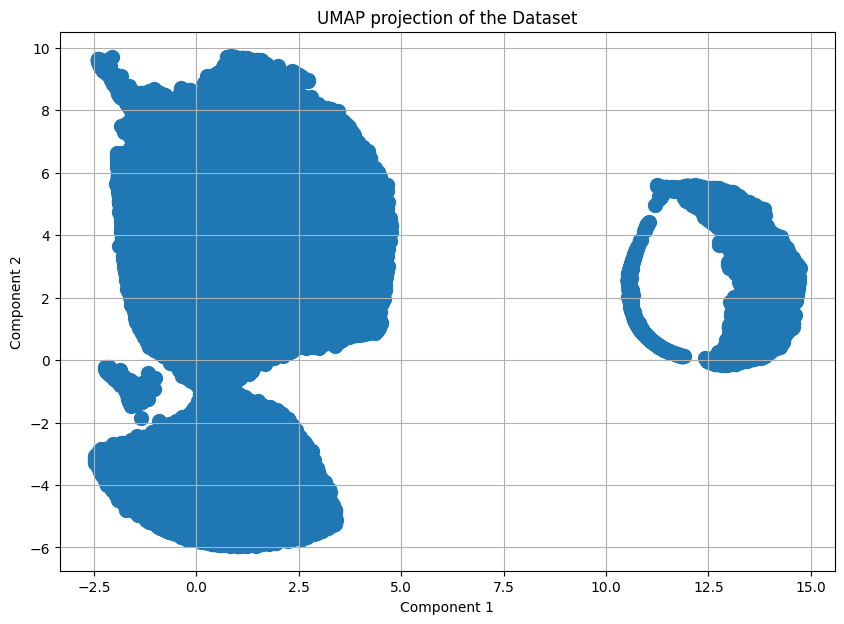

In [ ]:
# Plotting
plt.rcParams.update({"text.usetex": False})
plt.figure(figsize=(10, 7))
plt.scatter(embedding_df['Component 1'], embedding_df['Component 2'], s=100)
plt.title('UMAP projection of the Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()


In [ ]:
fig = plot_static_mapper_graph(pipe, df_4.values)
fig.show(config={'scrollZoom': True})

In [ ]:
fig = plot_static_mapper_graph(pipe, df_1.values)
fig.show(config={'scrollZoom': True})

In [ ]:
fig = plot_static_mapper_graph(pipe, df_2.values)
fig.show(config={'scrollZoom': True})

# ~~Check elbow point for thresholds~~ (disregarded)



In [ ]:
def test_gene_expression_thresholds(adata, cell_type, thresholds):
    """
    Tests various thresholds for gene filtering by minimum cell counts and plots the number of genes retained
    for each threshold for a specified cell type.

    Parameters:
        adata (AnnData): The AnnData object containing the dataset.
        cell_type (str): The specific cell type to analyze.
        thresholds (list or array): A list or array of threshold percentages to test.

    Returns:
        None: This function plots a graph and does not return any data.
    """
    gene_counts = []

    # Filter dataset for specific cell type
    cell_ds = adata[adata.obs['cell_type'] == cell_type]

    for threshold in tqdm(thresholds):
        # Calculate the minimum number of cells per gene threshold
        min_cell_threshold = int(np.ceil(threshold * cell_ds.shape[0]))

        # Filter genes based on the current threshold
        sc.pp.filter_genes(cell_ds, min_cells=min_cell_threshold)

        # Count the number of genes remaining after filtering
        n_genes = cell_ds.var.shape[0]
        gene_counts.append(n_genes)

        del cell_ds

    # Plotting the results
    plt.rcParams.update({"text.usetex": False})
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, gene_counts, marker='o')
    plt.title(f'Number of Genes Retained vs. Threshold for {cell_type}')
    plt.xlabel('Threshold Percentage')
    plt.ylabel('Number of Genes Retained')
    plt.grid(True)
    plt.show();

    return gene_counts

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client
import dask.array as da
import scanpy as sc
import scipy.sparse as sp

def test_gene_expression_thresholds_dask(adata, cell_type, thresholds):
    """
    Tests various thresholds for gene filtering by minimum cell counts using Dask for parallel processing
    and plots the number of genes retained for each threshold for a specified cell type, processing data column-wise.

    Parameters:
        adata (AnnData): The AnnData object containing the dataset.
        cell_type (str): The specific cell type to analyze.
        thresholds (list or array): A list or array of threshold percentages to test.

    Returns:
        None: This function plots a graph and does not return any data.
    """
    client = Client()  # Initializes a Dask client to manage workers

    # Filter dataset for specific cell type
    cell_mask = adata.obs['cell_type'] == cell_type
    cell_ds = adata[cell_mask].copy()

    # Check if the matrix is sparse and handle it appropriately
    if sp.issparse(cell_ds.X):
        # Convert sparse matrix to a Dask array
        x_dask = da.from_array(cell_ds.X, chunks=(cell_ds.shape[0], 100))  # Chunks are set column-wise
        # Sum over cells (rows) without using keepdims
        gene_sum = x_dask.sum(axis=0).compute()
    else:
        # If the matrix is already dense, handle with Dask directly
        x_dask = da.from_array(cell_ds.X, chunks=(cell_ds.shape[0], 100))
        gene_sum = x_dask.sum(axis=0).compute()

    gene_counts = []
    for threshold in thresholds:
        min_cell_threshold = int(np.ceil(threshold * cell_ds.shape[0]))

        # Filtering genes based on computed sums
        gene_mask = gene_sum >= min_cell_threshold

        # Count genes
        n_genes = np.count_nonzero(gene_mask)
        gene_counts.append(n_genes)

    client.close()  # Shutdown Dask client

    # Plotting the results
    plt.rcParams.update({"text.usetex": False})
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, gene_counts, marker='o')
    plt.title(f'Number of Genes Retained vs. Threshold for {cell_type}')
    plt.xlabel('Threshold Percentage')
    plt.ylabel('Number of Genes Retained')
    plt.grid(True)
    plt.show()

# Example usage
# dataset = sc.read_h5ad('path_to_your_data.h5ad')
# cell_type = 'example_cell_type'
# thresholds = np.linspace(0.05, 0.95, 19)
# test_gene_expression_thresholds_dask(dataset, cell_type, thresholds)


In [ ]:
def find_elbow_point(thresholds, gene_counts):
  """
    Identifies the elbow (or knee) point in a dataset using the KneeLocator class.
    This method is useful for determining the optimal point on a curve, often used for selecting a threshold
    or cutoff point that balances between two competing metrics. This function specifically seeks to identify
    the point at which the curve transitions from steep to flat, indicating diminishing returns.

    Parameters:
        thresholds (array-like): The x-values of the data points, representing different threshold levels tested.
        gene_counts (array-like): The y-values of the data points, typically representing the number of genes retained
                                  at each threshold.

    Returns:
        tuple:
            - float: The x-value (threshold) at which the elbow is located.
            - float: The y-value (gene count) at the elbow point.

    Usage Example:
        # Example thresholds and gene counts
        thresholds = np.linspace(0.05, 0.95, 19)
        gene_counts = [500, 470, 430, 390, 350, 310, 280, 250, 230, 210, 190, 170, 150, 130, 110, 90, 70, 50, 30]
        elbow_threshold, elbow_gene_count = find_elbow_point(thresholds, gene_counts)
        print("Elbow at threshold:", elbow_threshold, "with gene count:", elbow_gene_count)
    """
  # Create a KneeLocator object to find the elbow
  kneedle = KneeLocator(thresholds, gene_counts, curve='convex', direction='decreasing')

  return kneedle.elbow, kneedle.elbow_y

In [ ]:
cell_type = 'fibroblast'
thresholds = np.linspace(0.05, 0.95, 19)  # Thresholds as previously defined
gene_counts = test_gene_expression_thresholds_dask(ds, cell_type, thresholds)  # You would get this from your previous function
elbow_threshold, elbow_genes = find_elbow_point(thresholds, gene_counts)
print(f"The optimal threshold is approximately: {elbow_threshold} with {elbow_genes} genes.")

/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45031 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:39331
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:45031/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39713'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45599'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35553'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34729'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:45459', name: 2, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:45459
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:37248
INFO:distributed.scheduler:Reg

TypeError: _cs_matrix.sum() got an unexpected keyword argument 'keepdims'

  0%|          | 0/19 [00:00<?, ?it/s]

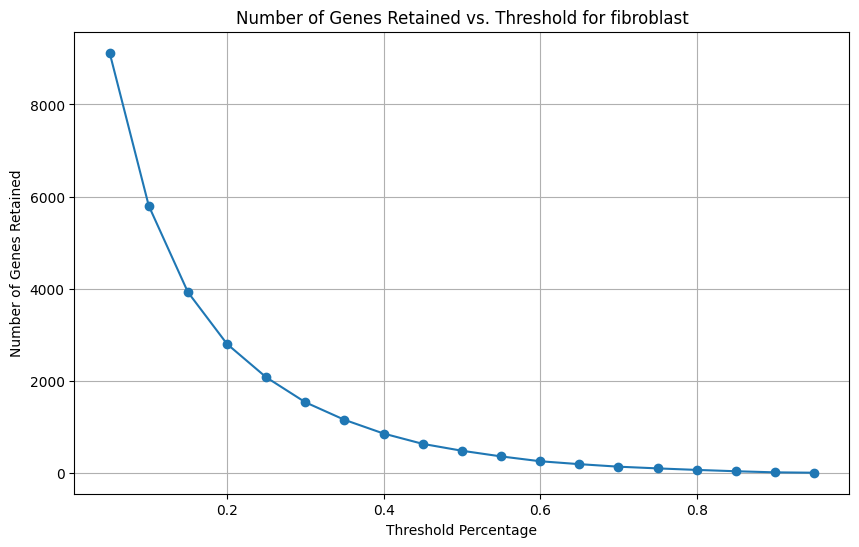

1538
The optimal threshold is approximately: 0.3


In [ ]:
cell_type = 'fibroblast'
thresholds = np.linspace(0.05, 0.95, 19)  # Thresholds as previously defined
gene_counts = test_gene_expression_thresholds(ds, cell_type, thresholds)  # You would get this from your previous function
elbow_threshold, elbow_genes = find_elbow_point(thresholds, gene_counts)
print(f"The optimal threshold is approximately: {elbow_threshold} with {elbow_genes} genes.")

In [ ]:
# Example usage with your data
for cell_type in tqdm(cell_types[1:]):
  thresholds = np.linspace(0.05, 0.95, 19)  # Thresholds as previously defined
  gene_counts = test_gene_expression_thresholds(ds, cell_type, thresholds)  # You would get this from your previous function
  elbow_threshold, elbow_genes = find_elbow_point(thresholds, gene_counts)
  print(f"The optimal threshold for {cell_type} is approximately: {elbow_threshold} with {elbow_genes} genes.")


  0%|          | 0/10 [00:00<?, ?it/s]

Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr

UnpicklingError: invalid load key, '?'.